# Network analysis in Senegal

### Objectives
    1)	Use measures of road-based accessibility to identify road segments that, if rehabilitated, would improve agricultural market activities in Senegal, including during flood conditions.
    2)	Gain a better understanding of the accessibility, connectivity, and criticality of roads in Senegal in relationship to agricultural origins, processing & transfer sites, and markets.

To this end, the team will develop an accessibility model which measures the travel time from sites of agricultural production to their nearest populated areas, processing centers, and markets. 

### Datasets for analysis
#### ORIGIN
    1) agriculture: MapSPAM 2017. Measuring value in international dollars.
    2) agriculture: UMD Land Cover 2019 30m. Assign MapSPAM value onto land cover cropland class for more precise origin information.
    3) population: WorldPop 2020, UN-adjusted.
    4) settlement extent: GRID3 2020.
#### DESTINATION
    4) markets: derived from WorldPop 2020 and GRID3 2020 urban clusters.
    5) agricultural processing hubs: to be acquired.
#### TRAVEL ROUTE
    6) roads: OpenStreetMap, July 2021.
    7) elevation: 
#### OBSTACLE
    8) flood: FATHOM. 1-in-10, 20, and 50 year flood return periods. These are combined pluvial and fluvial (undefended) flood layers whereby whichever flood level was higher was retained.
#### INTERVENTION
    9) upcoming road projects: AGEROUTE interventions separate from the World Bank-financed project
    10) targeted road projects: critical road segments identified by this accessibility model's baseline outputs


### Model design
#### Basic formula: 
    (a) Off-road driving time from origin to closest road node
    +
    (b) Driving time from road node in (a) to a destination (closeness measured by road segments speeds)

#### Model origin & destination (OD) sets:
    A)	Travel time from an area that has agricultural value/potential to the nearest processing hub (if provided).
    B)	Travel time from an area that has agricultural value/potential to the nearest larger settlement, (“larger” settlement identified using a case-appropriate population metric to be determined).
    C)	Travel time from an area that has agricultural value/potential to the nearest market.
    D)	Travel time from all settlements to the nearest market.
    E)	Travel time from larger settlements to the nearest market.

#### Before/after scenarios for each OD set:
    1)	Pre-project, baseline weather: No inclement weather. Road network status as of November 2021.
    2)	Pre-project, flood: 1-in-10, 1-in-20 and 1-in-50 year flood return period. Road network status as of November 2021.
    3)	Post-project, baseline weather: No inclement weather. Road network status if X number of critical road segments to high-value areas are protected (i.e., their travel times reduced).
    4)	Post-project, flood: 1-in-10 year flood return period. Road network status if X number of critical road segments to high-value areas are protected (i.e., their travel times reduced).

#### Notes:
    --Destinations are expected to be proximal to the road network, so no measure is taken between road and destination.
    --All travel times will be assigned to each model variation’s point of origin; the aggregation up to admin areas is possible if desired.
    --Obstacles & interventions modify the road segment speeds. Basic formula is then applied to the modified road network.


### Prep workspace

In [1]:
import os, sys
GISFolder = os.getcwd()
GISFolder

'C:\\Users\\wb527163\\GEO-Cdrive-Grace'

In [2]:
# Note: needed to reinstall rtree due to geopandas import error. Did so in the console. 
# conda install -c conda-forge rtree=0.9.3

In [2]:
# load and filter osm network (step 1)
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import time
sys.path.append(r"C:\Users\wb527163\.conda\envs\geo\GOSTnets-master")
import GOSTnets as gn

In [3]:
import networkx as nx
import osmnx as ox
import numpy as np
import rasterio as rt
import shapely
from shapely.geometry import Point, box, Polygon
from shapely.ops import unary_union, linemerge, transform
from shapely.wkt import loads
from shapely import wkt
from shapely.geometry import LineString, MultiLineString, Point
import peartree

In [4]:
#### Might not use these
import fiona
from osgeo import gdal
import importlib
import matplotlib.pyplot as plt
import subprocess, glob

In [5]:
from GOSTnets import load_osm as losm
import importlib

In [6]:
pth = os.path.join(GISFolder, "SEN-Cdrive") # Personal folder system for running model.
pth

'C:\\Users\\wb527163\\GEO-Cdrive-Grace\\SEN-Cdrive'

In [7]:
out_pth = os.path.join(GISFolder, "SEN-Cdrive\outputs") # For storing intermediate outputs from the model.
out_pth

'C:\\Users\\wb527163\\GEO-Cdrive-Grace\\SEN-Cdrive\\outputs'

In [8]:
team_pth = 'R:\\SEN\\GEO' # This is where the unmodified input data is stored. Finalized outputs also housed here.
team_pth

'R:\\SEN\\GEO'

### Prepare and clean the data

In [ ]:
# Notes:
# OSM road network is in WGS84. Projected each dataset to match.
# Starting as CSV (dataframe) and deriving geometry from there tends to avoid read errors.

<AxesSubplot:>

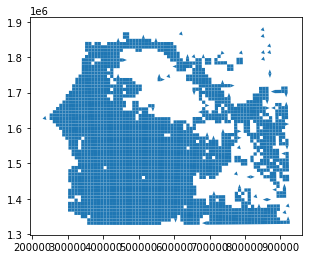

In [10]:
SPAM = gpd.read_file("SEN-Cdrive/spam2017.shp") 
SPAM = SPAM.to_crs('epsg:31028')
SPAM.plot()

In [11]:
LC = gpd.read_file("SEN-Cdrive/LC_dissolve.shp") 
LC = LC.to_crs('epsg:31028')

In [ ]:
LC.plot()

In [ ]:
# Split land cover by the SPAM grid so that they can be spatially joined.
SPAM_LC = SPAM.overlay(LC, how='intersection')

In [ ]:
SPAM_LC.info()

In [ ]:
SPAM_LC

In [ ]:
SPAM_LC.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/outputs/SPAM_LC.shp') 

In [ ]:
SPAM_LC.plot()

In [ ]:
# Reproject to get an equal area for area calculation
SPAM_LC = SPAM_LC.to_crs('epsg:102022')

In [ ]:
# Cropland areas that have agricultural value. Combined dataset of land cover and agricultural value.
agriculture = os.path.join(out_pth, "agriculture.csv")
agriculture = pd.read_csv(agriculture)
crs = "EPSG:4326"
geometry = [Point(xy) for xy in zip(agriculture.x, agriculture.y)]
agriculture = GeoDataFrame(agriculture, crs=crs, geometry=geometry) 
agriculture.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/outputs/agriculture.shp') 
agriculture.info()

In [ ]:
# High density areas, the proxy for markets
HDurban_extents = gpd.read_file("R:\SEN\GEO\Team\Projects\SEN_WPR_Urban\SEN_WPR_Urban.gdb", layer="SEN_urbanonly")
HDurban_extents.info()

In [ ]:
HDurban_extents = HDurban_extents[HDurban_extents['hd_urb']=="1"] # We only want high density urban areas.
HDurban_extents

In [ ]:
# Hamlets are the most dispersed populated areas
hamlet_extents = gpd.read_file("R:\SEN\GEO\Settlement_Extents\GRID3_SEN_settlement_extents_20200625.gdb", layer="hamlet_extents")
hamlet_extents.info()

#### Get centroids of polygonal origins and destinations. (HDurban and hamlet)

In [ ]:
# Reproject to projected CRS (UTM 28N) to allow for accurate centroid measure.
HDurban_extents = HDurban_extents.to_crs("EPSG:31028")
hamlet_extents = hamlet_extents.to_crs("EPSG:31028")
HDurban_extents.crs

In [ ]:
HDurban_extents['centroid'] = HDurban_extents['geometry'].centroid
hamlet_extents['centroid'] = hamlet_extents['geometry'].centroid
HDurban_extents

In [ ]:
hamlet_extents

Prefer it in X,Y columns, so here we're extracting the coordinates from the centroid geometry column:

In [ ]:
HDurban_extents.to_csv(os.path.join(out_pth, 'HDurban_extents.csv'))
HDurban_pt = os.path.join(out_pth, "HDurban_extents.csv")
HDurban_pt = pd.read_csv(HDurban_pt)
crs = {'init': 'epsg:31028'} 
HDurban_pt['centroid'] = HDurban_pt['centroid'].apply(wkt.loads) # It wasn't reading the centroid column as geometry at first.
HDurban_pt = HDurban_pt.drop(columns=['geometry']) # We need to get rid of the old geometry variables as soon as possible to avoid any interference with georeferencing later on.
HDurban_pt = GeoDataFrame(HDurban_pt, crs=crs, geometry='centroid') 
HDurban_pt.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/outputs/HDurban_pt.shp') 
HDurban_pt

In [ ]:
hamlet_extents.to_csv(os.path.join(out_pth, 'hamlet_extents.csv'))
hamlet_pt = os.path.join(out_pth, "hamlet_extents.csv")
hamlet_pt = pd.read_csv(hamlet_pt)
crs = {'init': 'epsg:31028'} 
hamlet_pt['centroid'] = hamlet_pt['centroid'].apply(wkt.loads)
hamlet_pt = hamlet_pt.drop(columns=['geometry']) # We need to get rid of the old geometry variables as soon as possible to avoid any interference with georeferencing later on.
hamlet_pt = GeoDataFrame(hamlet_pt, crs=crs, geometry='centroid') 
hamlet_pt.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/outputs/hamlet_pt.shp') 
hamlet_pt

In [ ]:
# The road graph will be in WGS84, so we'll start with that.
HDurban_pt = HDurban_pt.to_crs("EPSG:4326")
hamlet_pt = hamlet_pt.to_crs("EPSG:4326")

In [ ]:
HDurban_pt.info()

In [ ]:
hamlet_pt.head()

In [ ]:
# Check to confirm each file so far is the same coordinate system.
agriculture.crs

### Prepare OSM driving network.
Travel measured in length (meters).

In [10]:
fil = r'africa-latest.osm.pbf' # download this file from geofabrik.
f = os.path.join(out_pth, fil)
f

'C:\\Users\\wb527163\\GEO-Cdrive-Grace\\SEN-Cdrive\\outputs\\africa-latest.osm.pbf'

GOSTNets creates a special 'OSM_to_network' object. This object gets initialized with both a copy of the OSM file itself and the roads extracted from the OSM file in a GeoPandas DataFrame. This DataFrame is a property of the object called 'roads_raw' and is the starting point for our network.

In [11]:
# We are starting with the full Africa OSM file because we want to include roads surrounding the country as well.
print('start: %s\n' % time.ctime())
africa = OSM_to_network(f)
africa.roads_raw
print('\nend: %s' % time.ctime())
print('\n--- processing complete')
# Expect to take 1-2 hours.

start: Sat Nov 27 09:31:38 2021

skipping over reading other tags of osm_id: 4256821
skipping over reading other tags of osm_id: 4329964
skipping over reading other tags of osm_id: 4330123
skipping over reading other tags of osm_id: 4366003
skipping over reading other tags of osm_id: 4420332
skipping over reading other tags of osm_id: 4423933
skipping over reading other tags of osm_id: 4423935
skipping over reading other tags of osm_id: 4424014
skipping over reading other tags of osm_id: 4424515
skipping over reading other tags of osm_id: 4424571
skipping over reading other tags of osm_id: 4647990
skipping over reading other tags of osm_id: 4930359
skipping over reading other tags of osm_id: 4930690
skipping over reading other tags of osm_id: 4935045
skipping over reading other tags of osm_id: 5020067
skipping over reading other tags of osm_id: 5020071
skipping over reading other tags of osm_id: 5021957
skipping over reading other tags of osm_id: 5046000
skipping over reading other tag

skipping over reading other tags of osm_id: 28919902
skipping over reading other tags of osm_id: 28928358
skipping over reading other tags of osm_id: 28929234
skipping over reading other tags of osm_id: 28929235
skipping over reading other tags of osm_id: 29019803
skipping over reading other tags of osm_id: 29019889
skipping over reading other tags of osm_id: 29056514
skipping over reading other tags of osm_id: 29056516
skipping over reading other tags of osm_id: 29056517
skipping over reading other tags of osm_id: 29056520
skipping over reading other tags of osm_id: 29056521
skipping over reading other tags of osm_id: 29079261
skipping over reading other tags of osm_id: 29080866
skipping over reading other tags of osm_id: 29168881
skipping over reading other tags of osm_id: 29281422
skipping over reading other tags of osm_id: 29281645
skipping over reading other tags of osm_id: 29282110
skipping over reading other tags of osm_id: 29282227
skipping over reading other tags of osm_id: 29

skipping over reading other tags of osm_id: 41013568
skipping over reading other tags of osm_id: 41158076
skipping over reading other tags of osm_id: 41260638
skipping over reading other tags of osm_id: 41847366
skipping over reading other tags of osm_id: 42102111
skipping over reading other tags of osm_id: 42807786
skipping over reading other tags of osm_id: 43293316
skipping over reading other tags of osm_id: 43293694
skipping over reading other tags of osm_id: 43299185
skipping over reading other tags of osm_id: 43327596
skipping over reading other tags of osm_id: 43327926
skipping over reading other tags of osm_id: 43327927
skipping over reading other tags of osm_id: 43327931
skipping over reading other tags of osm_id: 43328438
skipping over reading other tags of osm_id: 43329418
skipping over reading other tags of osm_id: 43329420
skipping over reading other tags of osm_id: 43329425
skipping over reading other tags of osm_id: 43330260
skipping over reading other tags of osm_id: 43

skipping over reading other tags of osm_id: 61562790
skipping over reading other tags of osm_id: 66763864
skipping over reading other tags of osm_id: 68282871
skipping over reading other tags of osm_id: 68282872
skipping over reading other tags of osm_id: 68282875
skipping over reading other tags of osm_id: 68282879
skipping over reading other tags of osm_id: 68282883
skipping over reading other tags of osm_id: 68282888
skipping over reading other tags of osm_id: 68282892
skipping over reading other tags of osm_id: 68282897
skipping over reading other tags of osm_id: 69454295
skipping over reading other tags of osm_id: 69731559
skipping over reading other tags of osm_id: 69731566
skipping over reading other tags of osm_id: 70262506
skipping over reading other tags of osm_id: 70262507
skipping over reading other tags of osm_id: 71185118
skipping over reading other tags of osm_id: 71371089
skipping over reading other tags of osm_id: 71371098
skipping over reading other tags of osm_id: 71

skipping over reading other tags of osm_id: 89204538
skipping over reading other tags of osm_id: 89204571
skipping over reading other tags of osm_id: 89204579
skipping over reading other tags of osm_id: 89206594
skipping over reading other tags of osm_id: 89206602
skipping over reading other tags of osm_id: 89206623
skipping over reading other tags of osm_id: 89206627
skipping over reading other tags of osm_id: 89206629
skipping over reading other tags of osm_id: 89206631
skipping over reading other tags of osm_id: 89336020
skipping over reading other tags of osm_id: 89336055
skipping over reading other tags of osm_id: 89431058
skipping over reading other tags of osm_id: 89527554
skipping over reading other tags of osm_id: 89527556
skipping over reading other tags of osm_id: 89656061
skipping over reading other tags of osm_id: 89656074
skipping over reading other tags of osm_id: 89681916
skipping over reading other tags of osm_id: 89681932
skipping over reading other tags of osm_id: 89

skipping over reading other tags of osm_id: 97132325
skipping over reading other tags of osm_id: 97132328
skipping over reading other tags of osm_id: 97132374
skipping over reading other tags of osm_id: 97242106
skipping over reading other tags of osm_id: 97242127
skipping over reading other tags of osm_id: 97338414
skipping over reading other tags of osm_id: 97467962
skipping over reading other tags of osm_id: 97552663
skipping over reading other tags of osm_id: 97608307
skipping over reading other tags of osm_id: 97625637
skipping over reading other tags of osm_id: 97630648
skipping over reading other tags of osm_id: 97635659
skipping over reading other tags of osm_id: 97635663
skipping over reading other tags of osm_id: 97637313
skipping over reading other tags of osm_id: 97637747
skipping over reading other tags of osm_id: 97664255
skipping over reading other tags of osm_id: 97664257
skipping over reading other tags of osm_id: 97664259
skipping over reading other tags of osm_id: 97

skipping over reading other tags of osm_id: 99951382
skipping over reading other tags of osm_id: 99982925
skipping over reading other tags of osm_id: 99982926
skipping over reading other tags of osm_id: 99982937
skipping over reading other tags of osm_id: 99982939
skipping over reading other tags of osm_id: 99982940
skipping over reading other tags of osm_id: 99982941
skipping over reading other tags of osm_id: 99982947
skipping over reading other tags of osm_id: 99982958
skipping over reading other tags of osm_id: 99982961
skipping over reading other tags of osm_id: 99984351
skipping over reading other tags of osm_id: 99984368
skipping over reading other tags of osm_id: 100010186
skipping over reading other tags of osm_id: 100011990
skipping over reading other tags of osm_id: 100011991
skipping over reading other tags of osm_id: 100013220
skipping over reading other tags of osm_id: 100058301
skipping over reading other tags of osm_id: 100058379
skipping over reading other tags of osm_

skipping over reading other tags of osm_id: 110665877
skipping over reading other tags of osm_id: 111991049
skipping over reading other tags of osm_id: 112433572
skipping over reading other tags of osm_id: 112433573
skipping over reading other tags of osm_id: 112754643
skipping over reading other tags of osm_id: 113033632
skipping over reading other tags of osm_id: 113033635
skipping over reading other tags of osm_id: 113033636
skipping over reading other tags of osm_id: 113038865
skipping over reading other tags of osm_id: 113197330
skipping over reading other tags of osm_id: 113261911
skipping over reading other tags of osm_id: 113561191
skipping over reading other tags of osm_id: 113585758
skipping over reading other tags of osm_id: 114119124
skipping over reading other tags of osm_id: 115415415
skipping over reading other tags of osm_id: 115415416
skipping over reading other tags of osm_id: 115415421
skipping over reading other tags of osm_id: 115743116
skipping over reading other 

skipping over reading other tags of osm_id: 144956398
skipping over reading other tags of osm_id: 144957080
skipping over reading other tags of osm_id: 144958077
skipping over reading other tags of osm_id: 144958264
skipping over reading other tags of osm_id: 144993422
skipping over reading other tags of osm_id: 144993430
skipping over reading other tags of osm_id: 144993434
skipping over reading other tags of osm_id: 144993446
skipping over reading other tags of osm_id: 144993449
skipping over reading other tags of osm_id: 145004856
skipping over reading other tags of osm_id: 145103322
skipping over reading other tags of osm_id: 145109742
skipping over reading other tags of osm_id: 145109743
skipping over reading other tags of osm_id: 145109744
skipping over reading other tags of osm_id: 145109746
skipping over reading other tags of osm_id: 145109750
skipping over reading other tags of osm_id: 145129078
skipping over reading other tags of osm_id: 145131823
skipping over reading other 

skipping over reading other tags of osm_id: 159094060
skipping over reading other tags of osm_id: 159094062
skipping over reading other tags of osm_id: 159336223
skipping over reading other tags of osm_id: 159351409
skipping over reading other tags of osm_id: 159421489
skipping over reading other tags of osm_id: 159421496
skipping over reading other tags of osm_id: 159528428
skipping over reading other tags of osm_id: 159537862
skipping over reading other tags of osm_id: 159800126
skipping over reading other tags of osm_id: 159915675
skipping over reading other tags of osm_id: 159915681
skipping over reading other tags of osm_id: 160067584
skipping over reading other tags of osm_id: 160895507
skipping over reading other tags of osm_id: 161391194
skipping over reading other tags of osm_id: 161721904
skipping over reading other tags of osm_id: 161967064
skipping over reading other tags of osm_id: 162113968
skipping over reading other tags of osm_id: 162664880
skipping over reading other 

skipping over reading other tags of osm_id: 176085623
skipping over reading other tags of osm_id: 176085628
skipping over reading other tags of osm_id: 176085631
skipping over reading other tags of osm_id: 176093249
skipping over reading other tags of osm_id: 176132506
skipping over reading other tags of osm_id: 176177513
skipping over reading other tags of osm_id: 176177517
skipping over reading other tags of osm_id: 176177532
skipping over reading other tags of osm_id: 176179180
skipping over reading other tags of osm_id: 176198447
skipping over reading other tags of osm_id: 176204217
skipping over reading other tags of osm_id: 176205316
skipping over reading other tags of osm_id: 177227742
skipping over reading other tags of osm_id: 177231764
skipping over reading other tags of osm_id: 178227864
skipping over reading other tags of osm_id: 178252877
skipping over reading other tags of osm_id: 178568413
skipping over reading other tags of osm_id: 178570440
skipping over reading other 

skipping over reading other tags of osm_id: 196773885
skipping over reading other tags of osm_id: 196773886
skipping over reading other tags of osm_id: 196773887
skipping over reading other tags of osm_id: 196773888
skipping over reading other tags of osm_id: 196773889
skipping over reading other tags of osm_id: 196773890
skipping over reading other tags of osm_id: 196773891
skipping over reading other tags of osm_id: 196773892
skipping over reading other tags of osm_id: 196773893
skipping over reading other tags of osm_id: 196773894
skipping over reading other tags of osm_id: 196778115
skipping over reading other tags of osm_id: 196778116
skipping over reading other tags of osm_id: 196778117
skipping over reading other tags of osm_id: 196822564
skipping over reading other tags of osm_id: 196823406
skipping over reading other tags of osm_id: 196898086
skipping over reading other tags of osm_id: 196898087
skipping over reading other tags of osm_id: 196898088
skipping over reading other 

skipping over reading other tags of osm_id: 204044839
skipping over reading other tags of osm_id: 204090834
skipping over reading other tags of osm_id: 204135511
skipping over reading other tags of osm_id: 204178168
skipping over reading other tags of osm_id: 204241131
skipping over reading other tags of osm_id: 204242162
skipping over reading other tags of osm_id: 204273574
skipping over reading other tags of osm_id: 204317205
skipping over reading other tags of osm_id: 205627041
skipping over reading other tags of osm_id: 205834508
skipping over reading other tags of osm_id: 207505685
skipping over reading other tags of osm_id: 211815000
skipping over reading other tags of osm_id: 215289920
skipping over reading other tags of osm_id: 215391579
skipping over reading other tags of osm_id: 215492893
skipping over reading other tags of osm_id: 215667085
skipping over reading other tags of osm_id: 215667090
skipping over reading other tags of osm_id: 215667098
skipping over reading other 

skipping over reading other tags of osm_id: 252655607
skipping over reading other tags of osm_id: 252988987
skipping over reading other tags of osm_id: 253444719
skipping over reading other tags of osm_id: 253962153
skipping over reading other tags of osm_id: 253962155
skipping over reading other tags of osm_id: 253990539
skipping over reading other tags of osm_id: 254650300
skipping over reading other tags of osm_id: 254650303
skipping over reading other tags of osm_id: 254650304
skipping over reading other tags of osm_id: 254766121
skipping over reading other tags of osm_id: 254845703
skipping over reading other tags of osm_id: 254846497
skipping over reading other tags of osm_id: 254915973
skipping over reading other tags of osm_id: 255366389
skipping over reading other tags of osm_id: 256776258
skipping over reading other tags of osm_id: 256874385
skipping over reading other tags of osm_id: 256874398
skipping over reading other tags of osm_id: 256874401
skipping over reading other 

skipping over reading other tags of osm_id: 297342707
skipping over reading other tags of osm_id: 297343098
skipping over reading other tags of osm_id: 297883417
skipping over reading other tags of osm_id: 297883418
skipping over reading other tags of osm_id: 297883426
skipping over reading other tags of osm_id: 297883428
skipping over reading other tags of osm_id: 298447362
skipping over reading other tags of osm_id: 298996932
skipping over reading other tags of osm_id: 299003133
skipping over reading other tags of osm_id: 301071293
skipping over reading other tags of osm_id: 301071294
skipping over reading other tags of osm_id: 301077470
skipping over reading other tags of osm_id: 301077471
skipping over reading other tags of osm_id: 301626015
skipping over reading other tags of osm_id: 301626016
skipping over reading other tags of osm_id: 301626017
skipping over reading other tags of osm_id: 301724673
skipping over reading other tags of osm_id: 301724680
skipping over reading other 

skipping over reading other tags of osm_id: 344562920
skipping over reading other tags of osm_id: 350146650
skipping over reading other tags of osm_id: 350473955
skipping over reading other tags of osm_id: 353459920
skipping over reading other tags of osm_id: 353534850
skipping over reading other tags of osm_id: 353534858
skipping over reading other tags of osm_id: 353534863
skipping over reading other tags of osm_id: 353534873
skipping over reading other tags of osm_id: 353534874
skipping over reading other tags of osm_id: 353534886
skipping over reading other tags of osm_id: 353534887
skipping over reading other tags of osm_id: 353534889
skipping over reading other tags of osm_id: 355137824
skipping over reading other tags of osm_id: 355137825
skipping over reading other tags of osm_id: 355137826
skipping over reading other tags of osm_id: 355137827
skipping over reading other tags of osm_id: 355197618
skipping over reading other tags of osm_id: 355197619
skipping over reading other 

skipping over reading other tags of osm_id: 394425143
skipping over reading other tags of osm_id: 394442251
skipping over reading other tags of osm_id: 394443726
skipping over reading other tags of osm_id: 394458637
skipping over reading other tags of osm_id: 394497743
skipping over reading other tags of osm_id: 394497754
skipping over reading other tags of osm_id: 394497759
skipping over reading other tags of osm_id: 394497764
skipping over reading other tags of osm_id: 394497765
skipping over reading other tags of osm_id: 394497766
skipping over reading other tags of osm_id: 394692638
skipping over reading other tags of osm_id: 395315205
skipping over reading other tags of osm_id: 395362587
skipping over reading other tags of osm_id: 395538035
skipping over reading other tags of osm_id: 395538036
skipping over reading other tags of osm_id: 395619960
skipping over reading other tags of osm_id: 396067645
skipping over reading other tags of osm_id: 396093581
skipping over reading other 

skipping over reading other tags of osm_id: 418632255
skipping over reading other tags of osm_id: 418632545
skipping over reading other tags of osm_id: 418632550
skipping over reading other tags of osm_id: 418632596
skipping over reading other tags of osm_id: 418632613
skipping over reading other tags of osm_id: 418632982
skipping over reading other tags of osm_id: 418633244
skipping over reading other tags of osm_id: 418633353
skipping over reading other tags of osm_id: 418633597
skipping over reading other tags of osm_id: 418633648
skipping over reading other tags of osm_id: 418633717
skipping over reading other tags of osm_id: 418633741
skipping over reading other tags of osm_id: 418634087
skipping over reading other tags of osm_id: 418634148
skipping over reading other tags of osm_id: 418650773
skipping over reading other tags of osm_id: 418650860
skipping over reading other tags of osm_id: 418652719
skipping over reading other tags of osm_id: 418653047
skipping over reading other 

skipping over reading other tags of osm_id: 419067971
skipping over reading other tags of osm_id: 419068218
skipping over reading other tags of osm_id: 419068230
skipping over reading other tags of osm_id: 419068413
skipping over reading other tags of osm_id: 419068715
skipping over reading other tags of osm_id: 419069179
skipping over reading other tags of osm_id: 419069276
skipping over reading other tags of osm_id: 419069565
skipping over reading other tags of osm_id: 419070057
skipping over reading other tags of osm_id: 419070103
skipping over reading other tags of osm_id: 419070167
skipping over reading other tags of osm_id: 419070505
skipping over reading other tags of osm_id: 419070684
skipping over reading other tags of osm_id: 419070757
skipping over reading other tags of osm_id: 419090629
skipping over reading other tags of osm_id: 419090821
skipping over reading other tags of osm_id: 419090945
skipping over reading other tags of osm_id: 419091379
skipping over reading other 

skipping over reading other tags of osm_id: 433930895
skipping over reading other tags of osm_id: 433936534
skipping over reading other tags of osm_id: 433938483
skipping over reading other tags of osm_id: 433939055
skipping over reading other tags of osm_id: 433939143
skipping over reading other tags of osm_id: 433947309
skipping over reading other tags of osm_id: 433988520
skipping over reading other tags of osm_id: 433989816
skipping over reading other tags of osm_id: 433990867
skipping over reading other tags of osm_id: 433991420
skipping over reading other tags of osm_id: 433994763
skipping over reading other tags of osm_id: 433995067
skipping over reading other tags of osm_id: 433995251
skipping over reading other tags of osm_id: 434016853
skipping over reading other tags of osm_id: 434028596
skipping over reading other tags of osm_id: 434029346
skipping over reading other tags of osm_id: 434030634
skipping over reading other tags of osm_id: 434050533
skipping over reading other 

skipping over reading other tags of osm_id: 474427089
skipping over reading other tags of osm_id: 474497923
skipping over reading other tags of osm_id: 474498407
skipping over reading other tags of osm_id: 474498408
skipping over reading other tags of osm_id: 474879084
skipping over reading other tags of osm_id: 475601484
skipping over reading other tags of osm_id: 477792726
skipping over reading other tags of osm_id: 478012379
skipping over reading other tags of osm_id: 478012380
skipping over reading other tags of osm_id: 478012381
skipping over reading other tags of osm_id: 478012382
skipping over reading other tags of osm_id: 478497333
skipping over reading other tags of osm_id: 478991809
skipping over reading other tags of osm_id: 478993229
skipping over reading other tags of osm_id: 479303432
skipping over reading other tags of osm_id: 479345149
skipping over reading other tags of osm_id: 479345152
skipping over reading other tags of osm_id: 480483215
skipping over reading other 

skipping over reading other tags of osm_id: 533210774
skipping over reading other tags of osm_id: 533476296
skipping over reading other tags of osm_id: 533476297
skipping over reading other tags of osm_id: 533476298
skipping over reading other tags of osm_id: 533476310
skipping over reading other tags of osm_id: 533528889
skipping over reading other tags of osm_id: 534060388
skipping over reading other tags of osm_id: 534060389
skipping over reading other tags of osm_id: 534344732
skipping over reading other tags of osm_id: 537017494
skipping over reading other tags of osm_id: 537017495
skipping over reading other tags of osm_id: 537071991
skipping over reading other tags of osm_id: 538214700
skipping over reading other tags of osm_id: 538596995
skipping over reading other tags of osm_id: 539074340
skipping over reading other tags of osm_id: 539235912
skipping over reading other tags of osm_id: 539235920
skipping over reading other tags of osm_id: 539235926
skipping over reading other 

skipping over reading other tags of osm_id: 579045662
skipping over reading other tags of osm_id: 579045671
skipping over reading other tags of osm_id: 579045674
skipping over reading other tags of osm_id: 579318047
skipping over reading other tags of osm_id: 579424168
skipping over reading other tags of osm_id: 579435715
skipping over reading other tags of osm_id: 579435719
skipping over reading other tags of osm_id: 579435740
skipping over reading other tags of osm_id: 579435742
skipping over reading other tags of osm_id: 579950914
skipping over reading other tags of osm_id: 580134987
skipping over reading other tags of osm_id: 580857060
skipping over reading other tags of osm_id: 580857064
skipping over reading other tags of osm_id: 580857069
skipping over reading other tags of osm_id: 580857073
skipping over reading other tags of osm_id: 581328913
skipping over reading other tags of osm_id: 581328914
skipping over reading other tags of osm_id: 581345146
skipping over reading other 

skipping over reading other tags of osm_id: 590596069
skipping over reading other tags of osm_id: 590772371
skipping over reading other tags of osm_id: 590772372
skipping over reading other tags of osm_id: 590772373
skipping over reading other tags of osm_id: 590855843
skipping over reading other tags of osm_id: 591021809
skipping over reading other tags of osm_id: 591021810
skipping over reading other tags of osm_id: 591263089
skipping over reading other tags of osm_id: 591693383
skipping over reading other tags of osm_id: 591693395
skipping over reading other tags of osm_id: 592043536
skipping over reading other tags of osm_id: 592094316
skipping over reading other tags of osm_id: 592161654
skipping over reading other tags of osm_id: 592762809
skipping over reading other tags of osm_id: 593194504
skipping over reading other tags of osm_id: 594688947
skipping over reading other tags of osm_id: 594697068
skipping over reading other tags of osm_id: 594703231
skipping over reading other 

skipping over reading other tags of osm_id: 624645918
skipping over reading other tags of osm_id: 624815054
skipping over reading other tags of osm_id: 624815056
skipping over reading other tags of osm_id: 624815070
skipping over reading other tags of osm_id: 624815071
skipping over reading other tags of osm_id: 625610777
skipping over reading other tags of osm_id: 626764191
skipping over reading other tags of osm_id: 628168615
skipping over reading other tags of osm_id: 630046508
skipping over reading other tags of osm_id: 630214338
skipping over reading other tags of osm_id: 631178687
skipping over reading other tags of osm_id: 631956196
skipping over reading other tags of osm_id: 632004755
skipping over reading other tags of osm_id: 632493918
skipping over reading other tags of osm_id: 634814923
skipping over reading other tags of osm_id: 635967578
skipping over reading other tags of osm_id: 636393474
skipping over reading other tags of osm_id: 637030465
skipping over reading other 

skipping over reading other tags of osm_id: 647546131
skipping over reading other tags of osm_id: 647548045
skipping over reading other tags of osm_id: 647548046
skipping over reading other tags of osm_id: 648494571
skipping over reading other tags of osm_id: 648494572
skipping over reading other tags of osm_id: 648494573
skipping over reading other tags of osm_id: 648586137
skipping over reading other tags of osm_id: 648586140
skipping over reading other tags of osm_id: 648586147
skipping over reading other tags of osm_id: 651212288
skipping over reading other tags of osm_id: 651212308
skipping over reading other tags of osm_id: 651212309
skipping over reading other tags of osm_id: 651516286
skipping over reading other tags of osm_id: 651516288
skipping over reading other tags of osm_id: 652144087
skipping over reading other tags of osm_id: 652144088
skipping over reading other tags of osm_id: 652156820
skipping over reading other tags of osm_id: 652156828
skipping over reading other 

skipping over reading other tags of osm_id: 667132667
skipping over reading other tags of osm_id: 667132668
skipping over reading other tags of osm_id: 667132673
skipping over reading other tags of osm_id: 667132675
skipping over reading other tags of osm_id: 667132677
skipping over reading other tags of osm_id: 667132678
skipping over reading other tags of osm_id: 667132679
skipping over reading other tags of osm_id: 667132680
skipping over reading other tags of osm_id: 667132681
skipping over reading other tags of osm_id: 667132682
skipping over reading other tags of osm_id: 667132684
skipping over reading other tags of osm_id: 667132685
skipping over reading other tags of osm_id: 667132686
skipping over reading other tags of osm_id: 667132687
skipping over reading other tags of osm_id: 667132688
skipping over reading other tags of osm_id: 667132689
skipping over reading other tags of osm_id: 667132690
skipping over reading other tags of osm_id: 667132691
skipping over reading other 

skipping over reading other tags of osm_id: 667133216
skipping over reading other tags of osm_id: 667133218
skipping over reading other tags of osm_id: 667133219
skipping over reading other tags of osm_id: 667133221
skipping over reading other tags of osm_id: 667133222
skipping over reading other tags of osm_id: 667133223
skipping over reading other tags of osm_id: 667133224
skipping over reading other tags of osm_id: 667133225
skipping over reading other tags of osm_id: 667133227
skipping over reading other tags of osm_id: 667133229
skipping over reading other tags of osm_id: 667133231
skipping over reading other tags of osm_id: 667133232
skipping over reading other tags of osm_id: 667133233
skipping over reading other tags of osm_id: 667133234
skipping over reading other tags of osm_id: 667133235
skipping over reading other tags of osm_id: 667133237
skipping over reading other tags of osm_id: 667133239
skipping over reading other tags of osm_id: 667133241
skipping over reading other 

skipping over reading other tags of osm_id: 674420073
skipping over reading other tags of osm_id: 674420074
skipping over reading other tags of osm_id: 674420075
skipping over reading other tags of osm_id: 674420076
skipping over reading other tags of osm_id: 674420077
skipping over reading other tags of osm_id: 674420078
skipping over reading other tags of osm_id: 674420079
skipping over reading other tags of osm_id: 674420080
skipping over reading other tags of osm_id: 674420081
skipping over reading other tags of osm_id: 674420082
skipping over reading other tags of osm_id: 674420083
skipping over reading other tags of osm_id: 674420084
skipping over reading other tags of osm_id: 674420085
skipping over reading other tags of osm_id: 674420086
skipping over reading other tags of osm_id: 674420087
skipping over reading other tags of osm_id: 674420088
skipping over reading other tags of osm_id: 674420089
skipping over reading other tags of osm_id: 674420090
skipping over reading other 

skipping over reading other tags of osm_id: 674457247
skipping over reading other tags of osm_id: 674457248
skipping over reading other tags of osm_id: 674457249
skipping over reading other tags of osm_id: 674457250
skipping over reading other tags of osm_id: 674457251
skipping over reading other tags of osm_id: 674457252
skipping over reading other tags of osm_id: 674457253
skipping over reading other tags of osm_id: 674457254
skipping over reading other tags of osm_id: 674457255
skipping over reading other tags of osm_id: 674457256
skipping over reading other tags of osm_id: 674457257
skipping over reading other tags of osm_id: 674457258
skipping over reading other tags of osm_id: 674457259
skipping over reading other tags of osm_id: 674457260
skipping over reading other tags of osm_id: 674457261
skipping over reading other tags of osm_id: 674457262
skipping over reading other tags of osm_id: 674457263
skipping over reading other tags of osm_id: 674457264
skipping over reading other 

skipping over reading other tags of osm_id: 674954336
skipping over reading other tags of osm_id: 674954337
skipping over reading other tags of osm_id: 674954338
skipping over reading other tags of osm_id: 674954339
skipping over reading other tags of osm_id: 674986429
skipping over reading other tags of osm_id: 674989588
skipping over reading other tags of osm_id: 675082590
skipping over reading other tags of osm_id: 675095599
skipping over reading other tags of osm_id: 675096126
skipping over reading other tags of osm_id: 675096136
skipping over reading other tags of osm_id: 675109601
skipping over reading other tags of osm_id: 675118954
skipping over reading other tags of osm_id: 675150484
skipping over reading other tags of osm_id: 675150485
skipping over reading other tags of osm_id: 675152933
skipping over reading other tags of osm_id: 675157253
skipping over reading other tags of osm_id: 675157256
skipping over reading other tags of osm_id: 675163149
skipping over reading other 

skipping over reading other tags of osm_id: 681342202
skipping over reading other tags of osm_id: 681384241
skipping over reading other tags of osm_id: 681388051
skipping over reading other tags of osm_id: 681514132
skipping over reading other tags of osm_id: 681705551
skipping over reading other tags of osm_id: 682678995
skipping over reading other tags of osm_id: 682686356
skipping over reading other tags of osm_id: 682732200
skipping over reading other tags of osm_id: 682732204
skipping over reading other tags of osm_id: 683649945
skipping over reading other tags of osm_id: 684397125
skipping over reading other tags of osm_id: 685829946
skipping over reading other tags of osm_id: 685829950
skipping over reading other tags of osm_id: 685829953
skipping over reading other tags of osm_id: 685829956
skipping over reading other tags of osm_id: 685843372
skipping over reading other tags of osm_id: 685843375
skipping over reading other tags of osm_id: 685843381
skipping over reading other 

skipping over reading other tags of osm_id: 694465185
skipping over reading other tags of osm_id: 694465186
skipping over reading other tags of osm_id: 694465187
skipping over reading other tags of osm_id: 695035717
skipping over reading other tags of osm_id: 695035718
skipping over reading other tags of osm_id: 695035719
skipping over reading other tags of osm_id: 695035720
skipping over reading other tags of osm_id: 695398539
skipping over reading other tags of osm_id: 695603312
skipping over reading other tags of osm_id: 695604688
skipping over reading other tags of osm_id: 695657983
skipping over reading other tags of osm_id: 695657984
skipping over reading other tags of osm_id: 696061039
skipping over reading other tags of osm_id: 696419136
skipping over reading other tags of osm_id: 696493737
skipping over reading other tags of osm_id: 696493744
skipping over reading other tags of osm_id: 696611356
skipping over reading other tags of osm_id: 696624671
skipping over reading other 

skipping over reading other tags of osm_id: 712292308
skipping over reading other tags of osm_id: 712292309
skipping over reading other tags of osm_id: 712292310
skipping over reading other tags of osm_id: 712318680
skipping over reading other tags of osm_id: 712318681
skipping over reading other tags of osm_id: 712318690
skipping over reading other tags of osm_id: 712318691
skipping over reading other tags of osm_id: 712649534
skipping over reading other tags of osm_id: 712649536
skipping over reading other tags of osm_id: 713440007
skipping over reading other tags of osm_id: 713440008
skipping over reading other tags of osm_id: 713440010
skipping over reading other tags of osm_id: 713447194
skipping over reading other tags of osm_id: 713447195
skipping over reading other tags of osm_id: 713447196
skipping over reading other tags of osm_id: 713447197
skipping over reading other tags of osm_id: 714680931
skipping over reading other tags of osm_id: 715387181
skipping over reading other 

skipping over reading other tags of osm_id: 724764140
skipping over reading other tags of osm_id: 724770470
skipping over reading other tags of osm_id: 724872032
skipping over reading other tags of osm_id: 725089504
skipping over reading other tags of osm_id: 725089506
skipping over reading other tags of osm_id: 725389407
skipping over reading other tags of osm_id: 725411401
skipping over reading other tags of osm_id: 725455805
skipping over reading other tags of osm_id: 725455806
skipping over reading other tags of osm_id: 725756698
skipping over reading other tags of osm_id: 725756699
skipping over reading other tags of osm_id: 725756700
skipping over reading other tags of osm_id: 725756701
skipping over reading other tags of osm_id: 725806894
skipping over reading other tags of osm_id: 725857354
skipping over reading other tags of osm_id: 726086479
skipping over reading other tags of osm_id: 726112280
skipping over reading other tags of osm_id: 726112281
skipping over reading other 

skipping over reading other tags of osm_id: 729856756
skipping over reading other tags of osm_id: 729876851
skipping over reading other tags of osm_id: 729876854
skipping over reading other tags of osm_id: 729908368
skipping over reading other tags of osm_id: 729955648
skipping over reading other tags of osm_id: 729959362
skipping over reading other tags of osm_id: 729959369
skipping over reading other tags of osm_id: 729959370
skipping over reading other tags of osm_id: 729960623
skipping over reading other tags of osm_id: 729965753
skipping over reading other tags of osm_id: 729965754
skipping over reading other tags of osm_id: 729965764
skipping over reading other tags of osm_id: 729980286
skipping over reading other tags of osm_id: 729987463
skipping over reading other tags of osm_id: 729996808
skipping over reading other tags of osm_id: 730147790
skipping over reading other tags of osm_id: 730183657
skipping over reading other tags of osm_id: 730203729
skipping over reading other 

skipping over reading other tags of osm_id: 734114298
skipping over reading other tags of osm_id: 734114301
skipping over reading other tags of osm_id: 734114316
skipping over reading other tags of osm_id: 734130102
skipping over reading other tags of osm_id: 734132891
skipping over reading other tags of osm_id: 734410579
skipping over reading other tags of osm_id: 734424217
skipping over reading other tags of osm_id: 734430935
skipping over reading other tags of osm_id: 734443805
skipping over reading other tags of osm_id: 734446311
skipping over reading other tags of osm_id: 734476109
skipping over reading other tags of osm_id: 734476110
skipping over reading other tags of osm_id: 734507885
skipping over reading other tags of osm_id: 734507886
skipping over reading other tags of osm_id: 734507887
skipping over reading other tags of osm_id: 734507888
skipping over reading other tags of osm_id: 734509181
skipping over reading other tags of osm_id: 734509182
skipping over reading other 

skipping over reading other tags of osm_id: 738324110
skipping over reading other tags of osm_id: 738381171
skipping over reading other tags of osm_id: 738382047
skipping over reading other tags of osm_id: 738382048
skipping over reading other tags of osm_id: 738382049
skipping over reading other tags of osm_id: 738493059
skipping over reading other tags of osm_id: 738494110
skipping over reading other tags of osm_id: 738504588
skipping over reading other tags of osm_id: 738511089
skipping over reading other tags of osm_id: 738520780
skipping over reading other tags of osm_id: 738531386
skipping over reading other tags of osm_id: 738568729
skipping over reading other tags of osm_id: 738568730
skipping over reading other tags of osm_id: 738605963
skipping over reading other tags of osm_id: 738614920
skipping over reading other tags of osm_id: 738614921
skipping over reading other tags of osm_id: 738619889
skipping over reading other tags of osm_id: 739023286
skipping over reading other 

skipping over reading other tags of osm_id: 739882043
skipping over reading other tags of osm_id: 739882044
skipping over reading other tags of osm_id: 739884187
skipping over reading other tags of osm_id: 739889135
skipping over reading other tags of osm_id: 739895489
skipping over reading other tags of osm_id: 739895490
skipping over reading other tags of osm_id: 739899004
skipping over reading other tags of osm_id: 739904990
skipping over reading other tags of osm_id: 739905791
skipping over reading other tags of osm_id: 739905792
skipping over reading other tags of osm_id: 740107708
skipping over reading other tags of osm_id: 740112640
skipping over reading other tags of osm_id: 740117193
skipping over reading other tags of osm_id: 740117194
skipping over reading other tags of osm_id: 740126047
skipping over reading other tags of osm_id: 740126048
skipping over reading other tags of osm_id: 740130881
skipping over reading other tags of osm_id: 740132787
skipping over reading other 

skipping over reading other tags of osm_id: 743073501
skipping over reading other tags of osm_id: 743073502
skipping over reading other tags of osm_id: 743073503
skipping over reading other tags of osm_id: 743073504
skipping over reading other tags of osm_id: 743073575
skipping over reading other tags of osm_id: 743073723
skipping over reading other tags of osm_id: 743252846
skipping over reading other tags of osm_id: 743257641
skipping over reading other tags of osm_id: 743272500
skipping over reading other tags of osm_id: 743306969
skipping over reading other tags of osm_id: 743336883
skipping over reading other tags of osm_id: 743336884
skipping over reading other tags of osm_id: 743364384
skipping over reading other tags of osm_id: 744241251
skipping over reading other tags of osm_id: 744241252
skipping over reading other tags of osm_id: 744241253
skipping over reading other tags of osm_id: 744241254
skipping over reading other tags of osm_id: 744241255
skipping over reading other 

skipping over reading other tags of osm_id: 745282604
skipping over reading other tags of osm_id: 745282605
skipping over reading other tags of osm_id: 745282608
skipping over reading other tags of osm_id: 745282609
skipping over reading other tags of osm_id: 745295692
skipping over reading other tags of osm_id: 745341053
skipping over reading other tags of osm_id: 745366093
skipping over reading other tags of osm_id: 745366106
skipping over reading other tags of osm_id: 745372516
skipping over reading other tags of osm_id: 745372517
skipping over reading other tags of osm_id: 745391868
skipping over reading other tags of osm_id: 745534990
skipping over reading other tags of osm_id: 745534991
skipping over reading other tags of osm_id: 745534992
skipping over reading other tags of osm_id: 745534993
skipping over reading other tags of osm_id: 745534994
skipping over reading other tags of osm_id: 745534996
skipping over reading other tags of osm_id: 745534997
skipping over reading other 

skipping over reading other tags of osm_id: 747504010
skipping over reading other tags of osm_id: 747515094
skipping over reading other tags of osm_id: 747515095
skipping over reading other tags of osm_id: 747515096
skipping over reading other tags of osm_id: 747515097
skipping over reading other tags of osm_id: 747516020
skipping over reading other tags of osm_id: 747516021
skipping over reading other tags of osm_id: 747523416
skipping over reading other tags of osm_id: 747523417
skipping over reading other tags of osm_id: 747523418
skipping over reading other tags of osm_id: 747523419
skipping over reading other tags of osm_id: 747645895
skipping over reading other tags of osm_id: 747645896
skipping over reading other tags of osm_id: 747674171
skipping over reading other tags of osm_id: 747697873
skipping over reading other tags of osm_id: 747728216
skipping over reading other tags of osm_id: 747804583
skipping over reading other tags of osm_id: 747804584
skipping over reading other 

skipping over reading other tags of osm_id: 750206695
skipping over reading other tags of osm_id: 750209311
skipping over reading other tags of osm_id: 750213629
skipping over reading other tags of osm_id: 750323379
skipping over reading other tags of osm_id: 750323380
skipping over reading other tags of osm_id: 750323575
skipping over reading other tags of osm_id: 750325923
skipping over reading other tags of osm_id: 750326417
skipping over reading other tags of osm_id: 750326418
skipping over reading other tags of osm_id: 750326419
skipping over reading other tags of osm_id: 750329143
skipping over reading other tags of osm_id: 750329144
skipping over reading other tags of osm_id: 750330826
skipping over reading other tags of osm_id: 750330827
skipping over reading other tags of osm_id: 750330836
skipping over reading other tags of osm_id: 750330837
skipping over reading other tags of osm_id: 750330838
skipping over reading other tags of osm_id: 750330839
skipping over reading other 

skipping over reading other tags of osm_id: 751970007
skipping over reading other tags of osm_id: 751970008
skipping over reading other tags of osm_id: 752102889
skipping over reading other tags of osm_id: 752102890
skipping over reading other tags of osm_id: 752106357
skipping over reading other tags of osm_id: 752120554
skipping over reading other tags of osm_id: 752129284
skipping over reading other tags of osm_id: 752129285
skipping over reading other tags of osm_id: 752135677
skipping over reading other tags of osm_id: 752135679
skipping over reading other tags of osm_id: 752135684
skipping over reading other tags of osm_id: 752135687
skipping over reading other tags of osm_id: 752135689
skipping over reading other tags of osm_id: 752135699
skipping over reading other tags of osm_id: 752135701
skipping over reading other tags of osm_id: 752143678
skipping over reading other tags of osm_id: 752143679
skipping over reading other tags of osm_id: 752143680
skipping over reading other 

skipping over reading other tags of osm_id: 753185317
skipping over reading other tags of osm_id: 753185320
skipping over reading other tags of osm_id: 753188039
skipping over reading other tags of osm_id: 753188040
skipping over reading other tags of osm_id: 753188521
skipping over reading other tags of osm_id: 753198724
skipping over reading other tags of osm_id: 753198725
skipping over reading other tags of osm_id: 753206621
skipping over reading other tags of osm_id: 753206622
skipping over reading other tags of osm_id: 753239268
skipping over reading other tags of osm_id: 753239269
skipping over reading other tags of osm_id: 753239270
skipping over reading other tags of osm_id: 753239271
skipping over reading other tags of osm_id: 753241430
skipping over reading other tags of osm_id: 753246203
skipping over reading other tags of osm_id: 753283730
skipping over reading other tags of osm_id: 753301954
skipping over reading other tags of osm_id: 753306403
skipping over reading other 

skipping over reading other tags of osm_id: 755160439
skipping over reading other tags of osm_id: 755168942
skipping over reading other tags of osm_id: 755174750
skipping over reading other tags of osm_id: 755215713
skipping over reading other tags of osm_id: 755260094
skipping over reading other tags of osm_id: 755668863
skipping over reading other tags of osm_id: 755798567
skipping over reading other tags of osm_id: 755807703
skipping over reading other tags of osm_id: 755807704
skipping over reading other tags of osm_id: 755807705
skipping over reading other tags of osm_id: 755808940
skipping over reading other tags of osm_id: 755808941
skipping over reading other tags of osm_id: 755808943
skipping over reading other tags of osm_id: 755835364
skipping over reading other tags of osm_id: 755840570
skipping over reading other tags of osm_id: 755843811
skipping over reading other tags of osm_id: 755843833
skipping over reading other tags of osm_id: 755850856
skipping over reading other 

skipping over reading other tags of osm_id: 760095875
skipping over reading other tags of osm_id: 760095876
skipping over reading other tags of osm_id: 760095877
skipping over reading other tags of osm_id: 760126753
skipping over reading other tags of osm_id: 760126754
skipping over reading other tags of osm_id: 760126755
skipping over reading other tags of osm_id: 760150875
skipping over reading other tags of osm_id: 760176848
skipping over reading other tags of osm_id: 760176849
skipping over reading other tags of osm_id: 760185681
skipping over reading other tags of osm_id: 760234999
skipping over reading other tags of osm_id: 760235000
skipping over reading other tags of osm_id: 760240267
skipping over reading other tags of osm_id: 760240270
skipping over reading other tags of osm_id: 760241669
skipping over reading other tags of osm_id: 760443051
skipping over reading other tags of osm_id: 760476793
skipping over reading other tags of osm_id: 760476794
skipping over reading other 

skipping over reading other tags of osm_id: 765168536
skipping over reading other tags of osm_id: 765170896
skipping over reading other tags of osm_id: 765184464
skipping over reading other tags of osm_id: 765202779
skipping over reading other tags of osm_id: 765202780
skipping over reading other tags of osm_id: 765203789
skipping over reading other tags of osm_id: 765372180
skipping over reading other tags of osm_id: 765372182
skipping over reading other tags of osm_id: 765406625
skipping over reading other tags of osm_id: 765418816
skipping over reading other tags of osm_id: 765418819
skipping over reading other tags of osm_id: 765439638
skipping over reading other tags of osm_id: 765439639
skipping over reading other tags of osm_id: 765439653
skipping over reading other tags of osm_id: 765443321
skipping over reading other tags of osm_id: 765443322
skipping over reading other tags of osm_id: 765447949
skipping over reading other tags of osm_id: 765468673
skipping over reading other 

skipping over reading other tags of osm_id: 769375347
skipping over reading other tags of osm_id: 769381930
skipping over reading other tags of osm_id: 769400174
skipping over reading other tags of osm_id: 769417429
skipping over reading other tags of osm_id: 769417430
skipping over reading other tags of osm_id: 769538678
skipping over reading other tags of osm_id: 769614009
skipping over reading other tags of osm_id: 769633902
skipping over reading other tags of osm_id: 769661136
skipping over reading other tags of osm_id: 769665116
skipping over reading other tags of osm_id: 769688590
skipping over reading other tags of osm_id: 769721605
skipping over reading other tags of osm_id: 769721941
skipping over reading other tags of osm_id: 769915871
skipping over reading other tags of osm_id: 769939494
skipping over reading other tags of osm_id: 769947931
skipping over reading other tags of osm_id: 769947932
skipping over reading other tags of osm_id: 769947933
skipping over reading other 

skipping over reading other tags of osm_id: 775692797
skipping over reading other tags of osm_id: 775692798
skipping over reading other tags of osm_id: 775692799
skipping over reading other tags of osm_id: 775692800
skipping over reading other tags of osm_id: 776280095
skipping over reading other tags of osm_id: 776544257
skipping over reading other tags of osm_id: 776544261
skipping over reading other tags of osm_id: 776544267
skipping over reading other tags of osm_id: 776544268
skipping over reading other tags of osm_id: 777714196
skipping over reading other tags of osm_id: 777717760
skipping over reading other tags of osm_id: 777759438
skipping over reading other tags of osm_id: 778103501
skipping over reading other tags of osm_id: 778110921
skipping over reading other tags of osm_id: 778110924
skipping over reading other tags of osm_id: 778114363
skipping over reading other tags of osm_id: 778114364
skipping over reading other tags of osm_id: 778179454
skipping over reading other 

skipping over reading other tags of osm_id: 810280142
skipping over reading other tags of osm_id: 810280143
skipping over reading other tags of osm_id: 810280144
skipping over reading other tags of osm_id: 810280145
skipping over reading other tags of osm_id: 810280146
skipping over reading other tags of osm_id: 810416858
skipping over reading other tags of osm_id: 810416859
skipping over reading other tags of osm_id: 810553773
skipping over reading other tags of osm_id: 810702632
skipping over reading other tags of osm_id: 810744779
skipping over reading other tags of osm_id: 810744783
skipping over reading other tags of osm_id: 810744787
skipping over reading other tags of osm_id: 810788004
skipping over reading other tags of osm_id: 810788005
skipping over reading other tags of osm_id: 812407804
skipping over reading other tags of osm_id: 812592638
skipping over reading other tags of osm_id: 812601449
skipping over reading other tags of osm_id: 812614158
skipping over reading other 

skipping over reading other tags of osm_id: 819172160
skipping over reading other tags of osm_id: 819856301
skipping over reading other tags of osm_id: 819856302
skipping over reading other tags of osm_id: 820382878
skipping over reading other tags of osm_id: 820382879
skipping over reading other tags of osm_id: 820893332
skipping over reading other tags of osm_id: 820910481
skipping over reading other tags of osm_id: 820910491
skipping over reading other tags of osm_id: 820910492
skipping over reading other tags of osm_id: 820945596
skipping over reading other tags of osm_id: 820945597
skipping over reading other tags of osm_id: 820945605
skipping over reading other tags of osm_id: 821094772
skipping over reading other tags of osm_id: 821094777
skipping over reading other tags of osm_id: 821094778
skipping over reading other tags of osm_id: 821107898
skipping over reading other tags of osm_id: 821121601
skipping over reading other tags of osm_id: 821121602
skipping over reading other 

skipping over reading other tags of osm_id: 828461427
skipping over reading other tags of osm_id: 828461428
skipping over reading other tags of osm_id: 828473814
skipping over reading other tags of osm_id: 828473815
skipping over reading other tags of osm_id: 828473816
skipping over reading other tags of osm_id: 828473817
skipping over reading other tags of osm_id: 828473818
skipping over reading other tags of osm_id: 828473819
skipping over reading other tags of osm_id: 828473820
skipping over reading other tags of osm_id: 828473821
skipping over reading other tags of osm_id: 828473822
skipping over reading other tags of osm_id: 828473823
skipping over reading other tags of osm_id: 828473824
skipping over reading other tags of osm_id: 828473825
skipping over reading other tags of osm_id: 828473826
skipping over reading other tags of osm_id: 828473827
skipping over reading other tags of osm_id: 828473828
skipping over reading other tags of osm_id: 828473829
skipping over reading other 

skipping over reading other tags of osm_id: 830765940
skipping over reading other tags of osm_id: 830789346
skipping over reading other tags of osm_id: 830789353
skipping over reading other tags of osm_id: 830789363
skipping over reading other tags of osm_id: 830800909
skipping over reading other tags of osm_id: 830800910
skipping over reading other tags of osm_id: 830800935
skipping over reading other tags of osm_id: 830800936
skipping over reading other tags of osm_id: 830800939
skipping over reading other tags of osm_id: 830800940
skipping over reading other tags of osm_id: 830800941
skipping over reading other tags of osm_id: 830800942
skipping over reading other tags of osm_id: 830837351
skipping over reading other tags of osm_id: 831165454
skipping over reading other tags of osm_id: 831165457
skipping over reading other tags of osm_id: 831165458
skipping over reading other tags of osm_id: 831165459
skipping over reading other tags of osm_id: 831165460
skipping over reading other 

skipping over reading other tags of osm_id: 834109145
skipping over reading other tags of osm_id: 834170054
skipping over reading other tags of osm_id: 834170055
skipping over reading other tags of osm_id: 834170056
skipping over reading other tags of osm_id: 834170057
skipping over reading other tags of osm_id: 834174894
skipping over reading other tags of osm_id: 834175262
skipping over reading other tags of osm_id: 834181511
skipping over reading other tags of osm_id: 834181512
skipping over reading other tags of osm_id: 834209601
skipping over reading other tags of osm_id: 834249434
skipping over reading other tags of osm_id: 834249437
skipping over reading other tags of osm_id: 834249438
skipping over reading other tags of osm_id: 834249439
skipping over reading other tags of osm_id: 834249440
skipping over reading other tags of osm_id: 834249441
skipping over reading other tags of osm_id: 834249442
skipping over reading other tags of osm_id: 834249443
skipping over reading other 

skipping over reading other tags of osm_id: 835884771
skipping over reading other tags of osm_id: 836025645
skipping over reading other tags of osm_id: 836025646
skipping over reading other tags of osm_id: 836054026
skipping over reading other tags of osm_id: 836055142
skipping over reading other tags of osm_id: 836055143
skipping over reading other tags of osm_id: 836056919
skipping over reading other tags of osm_id: 836056920
skipping over reading other tags of osm_id: 836056959
skipping over reading other tags of osm_id: 836071638
skipping over reading other tags of osm_id: 836077753
skipping over reading other tags of osm_id: 836085218
skipping over reading other tags of osm_id: 836085219
skipping over reading other tags of osm_id: 836145834
skipping over reading other tags of osm_id: 836145835
skipping over reading other tags of osm_id: 836147481
skipping over reading other tags of osm_id: 836147482
skipping over reading other tags of osm_id: 836147483
skipping over reading other 

skipping over reading other tags of osm_id: 837929275
skipping over reading other tags of osm_id: 837929559
skipping over reading other tags of osm_id: 837929560
skipping over reading other tags of osm_id: 837929561
skipping over reading other tags of osm_id: 837929562
skipping over reading other tags of osm_id: 837929732
skipping over reading other tags of osm_id: 837929733
skipping over reading other tags of osm_id: 837929734
skipping over reading other tags of osm_id: 837929735
skipping over reading other tags of osm_id: 838077855
skipping over reading other tags of osm_id: 838077856
skipping over reading other tags of osm_id: 838088394
skipping over reading other tags of osm_id: 838088395
skipping over reading other tags of osm_id: 838151679
skipping over reading other tags of osm_id: 838151680
skipping over reading other tags of osm_id: 838151681
skipping over reading other tags of osm_id: 838151682
skipping over reading other tags of osm_id: 838153402
skipping over reading other 

skipping over reading other tags of osm_id: 838570483
skipping over reading other tags of osm_id: 838570484
skipping over reading other tags of osm_id: 838575026
skipping over reading other tags of osm_id: 838575027
skipping over reading other tags of osm_id: 838575028
skipping over reading other tags of osm_id: 838575029
skipping over reading other tags of osm_id: 838575030
skipping over reading other tags of osm_id: 838575031
skipping over reading other tags of osm_id: 838575033
skipping over reading other tags of osm_id: 838575038
skipping over reading other tags of osm_id: 838575039
skipping over reading other tags of osm_id: 838575040
skipping over reading other tags of osm_id: 838575041
skipping over reading other tags of osm_id: 838575042
skipping over reading other tags of osm_id: 838587495
skipping over reading other tags of osm_id: 838587497
skipping over reading other tags of osm_id: 838587498
skipping over reading other tags of osm_id: 838587501
skipping over reading other 

skipping over reading other tags of osm_id: 840599829
skipping over reading other tags of osm_id: 840599830
skipping over reading other tags of osm_id: 840599831
skipping over reading other tags of osm_id: 840599832
skipping over reading other tags of osm_id: 840599833
skipping over reading other tags of osm_id: 840599834
skipping over reading other tags of osm_id: 840600942
skipping over reading other tags of osm_id: 840600943
skipping over reading other tags of osm_id: 840606362
skipping over reading other tags of osm_id: 840606363
skipping over reading other tags of osm_id: 840832868
skipping over reading other tags of osm_id: 840832869
skipping over reading other tags of osm_id: 840842994
skipping over reading other tags of osm_id: 840842995
skipping over reading other tags of osm_id: 840860012
skipping over reading other tags of osm_id: 840860013
skipping over reading other tags of osm_id: 840860019
skipping over reading other tags of osm_id: 840860020
skipping over reading other 

skipping over reading other tags of osm_id: 844777847
skipping over reading other tags of osm_id: 844777848
skipping over reading other tags of osm_id: 844777853
skipping over reading other tags of osm_id: 844777854
skipping over reading other tags of osm_id: 844777875
skipping over reading other tags of osm_id: 844777876
skipping over reading other tags of osm_id: 844777877
skipping over reading other tags of osm_id: 844777878
skipping over reading other tags of osm_id: 844787236
skipping over reading other tags of osm_id: 844787237
skipping over reading other tags of osm_id: 844787238
skipping over reading other tags of osm_id: 844787239
skipping over reading other tags of osm_id: 844787240
skipping over reading other tags of osm_id: 844787241
skipping over reading other tags of osm_id: 844787253
skipping over reading other tags of osm_id: 844787254
skipping over reading other tags of osm_id: 844787262
skipping over reading other tags of osm_id: 844787263
skipping over reading other 

skipping over reading other tags of osm_id: 845643334
skipping over reading other tags of osm_id: 845643335
skipping over reading other tags of osm_id: 845643338
skipping over reading other tags of osm_id: 845650565
skipping over reading other tags of osm_id: 845650566
skipping over reading other tags of osm_id: 845650567
skipping over reading other tags of osm_id: 845650568
skipping over reading other tags of osm_id: 845650578
skipping over reading other tags of osm_id: 845650579
skipping over reading other tags of osm_id: 845650580
skipping over reading other tags of osm_id: 845650581
skipping over reading other tags of osm_id: 845654068
skipping over reading other tags of osm_id: 845654069
skipping over reading other tags of osm_id: 845675104
skipping over reading other tags of osm_id: 845675105
skipping over reading other tags of osm_id: 845675106
skipping over reading other tags of osm_id: 845675107
skipping over reading other tags of osm_id: 845757676
skipping over reading other 

skipping over reading other tags of osm_id: 848070781
skipping over reading other tags of osm_id: 848070782
skipping over reading other tags of osm_id: 848070784
skipping over reading other tags of osm_id: 848070785
skipping over reading other tags of osm_id: 848070786
skipping over reading other tags of osm_id: 848070787
skipping over reading other tags of osm_id: 848070788
skipping over reading other tags of osm_id: 848070789
skipping over reading other tags of osm_id: 848070790
skipping over reading other tags of osm_id: 848070791
skipping over reading other tags of osm_id: 848089894
skipping over reading other tags of osm_id: 848316559
skipping over reading other tags of osm_id: 848435985
skipping over reading other tags of osm_id: 848435986
skipping over reading other tags of osm_id: 848697814
skipping over reading other tags of osm_id: 848697815
skipping over reading other tags of osm_id: 849685429
skipping over reading other tags of osm_id: 849807223
skipping over reading other 

skipping over reading other tags of osm_id: 861033192
skipping over reading other tags of osm_id: 861033193
skipping over reading other tags of osm_id: 861033194
skipping over reading other tags of osm_id: 861033195
skipping over reading other tags of osm_id: 861033196
skipping over reading other tags of osm_id: 861033197
skipping over reading other tags of osm_id: 861036023
skipping over reading other tags of osm_id: 861068585
skipping over reading other tags of osm_id: 861068586
skipping over reading other tags of osm_id: 861068587
skipping over reading other tags of osm_id: 861068588
skipping over reading other tags of osm_id: 862054775
skipping over reading other tags of osm_id: 862054779
skipping over reading other tags of osm_id: 862054780
skipping over reading other tags of osm_id: 862054781
skipping over reading other tags of osm_id: 862054782
skipping over reading other tags of osm_id: 862081765
skipping over reading other tags of osm_id: 862081766
skipping over reading other 

skipping over reading other tags of osm_id: 870683509
skipping over reading other tags of osm_id: 870683510
skipping over reading other tags of osm_id: 870683511
skipping over reading other tags of osm_id: 870683512
skipping over reading other tags of osm_id: 870683513
skipping over reading other tags of osm_id: 870683514
skipping over reading other tags of osm_id: 870683515
skipping over reading other tags of osm_id: 870683516
skipping over reading other tags of osm_id: 870683517
skipping over reading other tags of osm_id: 870683518
skipping over reading other tags of osm_id: 870683519
skipping over reading other tags of osm_id: 870683520
skipping over reading other tags of osm_id: 870683522
skipping over reading other tags of osm_id: 870683523
skipping over reading other tags of osm_id: 870683524
skipping over reading other tags of osm_id: 870683525
skipping over reading other tags of osm_id: 870683528
skipping over reading other tags of osm_id: 870683529
skipping over reading other 

skipping over reading other tags of osm_id: 873450130
skipping over reading other tags of osm_id: 873450131
skipping over reading other tags of osm_id: 874025917
skipping over reading other tags of osm_id: 874025918
skipping over reading other tags of osm_id: 874025919
skipping over reading other tags of osm_id: 874025920
skipping over reading other tags of osm_id: 874025922
skipping over reading other tags of osm_id: 874025924
skipping over reading other tags of osm_id: 874025925
skipping over reading other tags of osm_id: 874025927
skipping over reading other tags of osm_id: 874025929
skipping over reading other tags of osm_id: 874025930
skipping over reading other tags of osm_id: 874025931
skipping over reading other tags of osm_id: 874025932
skipping over reading other tags of osm_id: 874025933
skipping over reading other tags of osm_id: 874025934
skipping over reading other tags of osm_id: 874025935
skipping over reading other tags of osm_id: 874025937
skipping over reading other 

skipping over reading other tags of osm_id: 876639509
skipping over reading other tags of osm_id: 876639510
skipping over reading other tags of osm_id: 876639513
skipping over reading other tags of osm_id: 876639514
skipping over reading other tags of osm_id: 877453894
skipping over reading other tags of osm_id: 877454398
skipping over reading other tags of osm_id: 877454399
skipping over reading other tags of osm_id: 877454400
skipping over reading other tags of osm_id: 877463127
skipping over reading other tags of osm_id: 877520799
skipping over reading other tags of osm_id: 877520800
skipping over reading other tags of osm_id: 877520801
skipping over reading other tags of osm_id: 877520802
skipping over reading other tags of osm_id: 877520803
skipping over reading other tags of osm_id: 877520804
skipping over reading other tags of osm_id: 877526866
skipping over reading other tags of osm_id: 877526867
skipping over reading other tags of osm_id: 877526868
skipping over reading other 

skipping over reading other tags of osm_id: 888867717
skipping over reading other tags of osm_id: 888887350
skipping over reading other tags of osm_id: 888887351
skipping over reading other tags of osm_id: 889566571
skipping over reading other tags of osm_id: 889566575
skipping over reading other tags of osm_id: 889566576
skipping over reading other tags of osm_id: 889582606
skipping over reading other tags of osm_id: 890092867
skipping over reading other tags of osm_id: 890092868
skipping over reading other tags of osm_id: 890193747
skipping over reading other tags of osm_id: 891800209
skipping over reading other tags of osm_id: 891800211
skipping over reading other tags of osm_id: 891831212
skipping over reading other tags of osm_id: 891960857
skipping over reading other tags of osm_id: 891960858
skipping over reading other tags of osm_id: 891960859
skipping over reading other tags of osm_id: 891960860
skipping over reading other tags of osm_id: 892643454
skipping over reading other 

skipping over reading other tags of osm_id: 905089318
skipping over reading other tags of osm_id: 905354081
skipping over reading other tags of osm_id: 905354097
skipping over reading other tags of osm_id: 905504121
skipping over reading other tags of osm_id: 905760477
skipping over reading other tags of osm_id: 905871499
skipping over reading other tags of osm_id: 905871500
skipping over reading other tags of osm_id: 907061543
skipping over reading other tags of osm_id: 907061544
skipping over reading other tags of osm_id: 907061547
skipping over reading other tags of osm_id: 907061548
skipping over reading other tags of osm_id: 907061549
skipping over reading other tags of osm_id: 907061550
skipping over reading other tags of osm_id: 907061551
skipping over reading other tags of osm_id: 907061554
skipping over reading other tags of osm_id: 907061558
skipping over reading other tags of osm_id: 907061559
skipping over reading other tags of osm_id: 907343159
skipping over reading other 

skipping over reading other tags of osm_id: 914979302
skipping over reading other tags of osm_id: 914979304
skipping over reading other tags of osm_id: 915041517
skipping over reading other tags of osm_id: 915041518
skipping over reading other tags of osm_id: 915041519
skipping over reading other tags of osm_id: 915041520
skipping over reading other tags of osm_id: 915062871
skipping over reading other tags of osm_id: 915062872
skipping over reading other tags of osm_id: 915062873
skipping over reading other tags of osm_id: 915062874
skipping over reading other tags of osm_id: 915062875
skipping over reading other tags of osm_id: 915062876
skipping over reading other tags of osm_id: 915062877
skipping over reading other tags of osm_id: 915521911
skipping over reading other tags of osm_id: 915534944
skipping over reading other tags of osm_id: 915754836
skipping over reading other tags of osm_id: 915855217
skipping over reading other tags of osm_id: 915855221
skipping over reading other 

skipping over reading other tags of osm_id: 920965525
skipping over reading other tags of osm_id: 920970933
skipping over reading other tags of osm_id: 920991485
skipping over reading other tags of osm_id: 920991486
skipping over reading other tags of osm_id: 920991487
skipping over reading other tags of osm_id: 921201023
skipping over reading other tags of osm_id: 921201024
skipping over reading other tags of osm_id: 921201025
skipping over reading other tags of osm_id: 921201026
skipping over reading other tags of osm_id: 921201027
skipping over reading other tags of osm_id: 921201028
skipping over reading other tags of osm_id: 921264221
skipping over reading other tags of osm_id: 921264222
skipping over reading other tags of osm_id: 921264223
skipping over reading other tags of osm_id: 921264224
skipping over reading other tags of osm_id: 921264225
skipping over reading other tags of osm_id: 921264226
skipping over reading other tags of osm_id: 921264227
skipping over reading other 

skipping over reading other tags of osm_id: 927093563
skipping over reading other tags of osm_id: 927093572
skipping over reading other tags of osm_id: 927634769
skipping over reading other tags of osm_id: 927675769
skipping over reading other tags of osm_id: 929146347
skipping over reading other tags of osm_id: 929146349
skipping over reading other tags of osm_id: 929565516
skipping over reading other tags of osm_id: 929565517
skipping over reading other tags of osm_id: 929565519
skipping over reading other tags of osm_id: 929565520
skipping over reading other tags of osm_id: 929759921
skipping over reading other tags of osm_id: 929759923
skipping over reading other tags of osm_id: 929915930
skipping over reading other tags of osm_id: 930438230
skipping over reading other tags of osm_id: 930439807
skipping over reading other tags of osm_id: 930588885
skipping over reading other tags of osm_id: 930597946
skipping over reading other tags of osm_id: 930612175
skipping over reading other 

skipping over reading other tags of osm_id: 948622129
skipping over reading other tags of osm_id: 948626596
skipping over reading other tags of osm_id: 948628227
skipping over reading other tags of osm_id: 948628228
skipping over reading other tags of osm_id: 948974969
skipping over reading other tags of osm_id: 949635441
skipping over reading other tags of osm_id: 949646911
skipping over reading other tags of osm_id: 949646914
skipping over reading other tags of osm_id: 949646915
skipping over reading other tags of osm_id: 949663716
skipping over reading other tags of osm_id: 949663720
skipping over reading other tags of osm_id: 949731004
skipping over reading other tags of osm_id: 949736008
skipping over reading other tags of osm_id: 949759873
skipping over reading other tags of osm_id: 949759874
skipping over reading other tags of osm_id: 949953208
skipping over reading other tags of osm_id: 950398077
skipping over reading other tags of osm_id: 950398079
skipping over reading other 

skipping over reading other tags of osm_id: 987150842
skipping over reading other tags of osm_id: 987431830
skipping over reading other tags of osm_id: 987431831
skipping over reading other tags of osm_id: 987431832
skipping over reading other tags of osm_id: 987431834
skipping over reading other tags of osm_id: 987517615
skipping over reading other tags of osm_id: 988073529
skipping over reading other tags of osm_id: 988282245
skipping over reading other tags of osm_id: 988306713
skipping over reading other tags of osm_id: 989093638
skipping over reading other tags of osm_id: 989372444
skipping over reading other tags of osm_id: 989559056
skipping over reading other tags of osm_id: 989559057
skipping over reading other tags of osm_id: 989720233
skipping over reading other tags of osm_id: 989720234
skipping over reading other tags of osm_id: 989720235
skipping over reading other tags of osm_id: 990302500
skipping over reading other tags of osm_id: 991206722
skipping over reading other 

C:\Users\wb527163\.conda\envs\geo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)



end: Sat Nov 27 11:01:43 2021

--- processing complete


<AxesSubplot:>

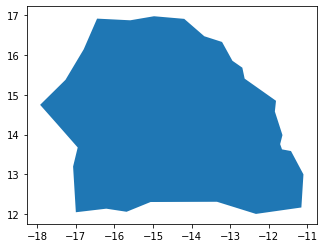

In [12]:
# Clip to a buffered area that includes all of Senegal, The Gambia, and nearby roads in neighboring countries. 
clip_shp = gpd.read_file("R:/SEN/GEO/Roads/bounding_senegam_buffered.shp") 
clip_shp = clip_shp.to_crs('epsg:4326')
clip_shp.plot()

In [13]:
bound = clip_shp.geometry.iloc[0] # This is a geometry object from shapely. Different from the GDF (clip_shp)

In [14]:
# Narrow down to the roads contained within the buffered Senegambia area.
africa.roads_raw = africa.roads_raw.loc[africa.roads_raw.geometry.intersects(bound) == True]

In [15]:
# Inspect the file. 
africa.roads_raw.infra_type.value_counts()

residential       174965
track              50338
unclassified       35686
service            12930
path                9422
tertiary            4170
footway             3273
secondary           1296
primary             1085
trunk                859
motorway_link        186
trunk_link           175
motorway             146
construction         129
pedestrian           126
road                  93
steps                 89
secondary_link        77
tertiary_link         60
primary_link          55
raceway               49
living_street         33
cycleway              17
bridleway             11
rest_area              3
services               1
Name: infra_type, dtype: int64

In [16]:
# Filter out the unnecessary road classes.
# Many OSM contributors for Senegal have used the "track" tag, so make sure that is retained in the speed dictionary.
accepted_road_types = ['residential', 
                       'unclassified', 
                       'path',
                       'track',
                       'service',
                       'tertiary',
                       'road',
                       'secondary',
                       'primary',
                       'trunk',
                       'primary_link','trunk_link','tertiary_link','secondary_link']
africa.filterRoads(acceptedRoads = accepted_road_types)
africa.roads_raw.infra_type.value_counts()

residential       174965
track              50338
unclassified       35686
service            12930
path                9422
tertiary            4170
secondary           1296
primary             1085
trunk                859
trunk_link           175
road                  93
secondary_link        77
tertiary_link         60
primary_link          55
Name: infra_type, dtype: int64

Having narrowed the DataFrame to the roads we are interested in, we generate the RoadsGPD object, which is stored as a property of the 'OSM_to_network' object. The RoadsGPD object is a GeoDataFrame that further processes the roads. This includes splitting the edges where intersections occur, adding unique edge IDs, and adding to/from columns to the GeoDataFrame.

In [17]:
print('start: %s\n' % time.ctime())
africa.generateRoadsGDF(verbose = False)
print('\nend: %s' % time.ctime())
print('\n--- processing complete')

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in inter:
C:\Users\wb527163\AppData\Local\Temp/ipykernel_16236/3783192782.py:293: ShapelyDeprecationWarning: Iteration over multi-part geometries 

In [18]:
# Create graph object.
africa.initialReadIn()

In [19]:
# Save to file as pickle, node csv, and edges csv.
gn.save(africa.network,'senegambia_unclean',os.path.join(pth, 'outputs'))

#### The network currently has many nodes that aren't useful in some areas, and not enough nodes to snap to in others. This section simplifies the graph and then produces nodes in long stretches of road.

In [ ]:
# I am starting a new session here to clear the workspace of that huge Africa object.
G_unclean = nx.read_gpickle(os.path.join(out_pth, 'senegambia_unclean.pickle'))

In [14]:
senegambia_UTM = {'init': 'epsg:31028'}
WGS = {'init': 'epsg:4326'} # do not adjust. OSM natively comes in ESPG 4326

In [21]:
?gn.clean_network

In [12]:
# A lot of errors happening with this one. I went into the module and only kept:
# add_missing_reflected_edges(G)
# custom_simplify(a)
# convert_to_MultiDiGraph(b)
# add_missing_reflected_edges(c)

print('start: %s\n' % time.ctime())
G_clean = gn.clean_network(G = G_unclean, wpath = pth, output_file_name = 'G_clean', UTM = senegambia_UTM, WGS = WGS, junctdist=20, verbose = True)
print('\nend: %s' % time.ctime())
print('\n--- processing complete')

start: Wed Dec  1 14:37:44 2021

completed processing 1554426 edges
completed processing 2957084 edges
Edge reduction: 777213 to 2957084 (-280 percent)

end: Wed Dec  1 15:01:18 2021

--- processing complete


In [14]:
gn.save(G_clean,'senegambia_cleaned',os.path.join(pth, 'outputs'))

In [10]:
# If starting new session
G_clean = nx.read_gpickle(os.path.join(out_pth, 'senegambia_cleaned.pickle'))

KeyboardInterrupt: 

In [ ]:
gn.example_edge(G_clean)

In [ ]:
gn.example_edge(G)

In [53]:
?gn.salt_long_lines

In [16]:
# Then add texture to areas that don't have enough nodes to snap to. 
# Important for getting accurate travel times from rural areas.

print('start: %s\n' % time.ctime())
G_salt = gn.salt_long_lines(G_clean, source = WGS, target = senegambia_UTM, thresh = 1000)
print('\nend: %s' % time.ctime())
print('\n--- processing complete')

start: Wed Dec  1 16:59:06 2021



C:\Users\wb527163\.conda\envs\geo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\wb527163\.conda\envs\geo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\wb527163\.conda\envs\geo\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. Wh

Identified 71170 unique edge(s) longer than 1000. 
Beginning new node creation...
446468 new edges added and 142360 removed to bring total edges to 3261192
152064 new nodes added to bring total nodes to 650927

end: Wed Dec  1 17:25:57 2021

--- processing complete


In [17]:
gn.save(G_salt,'senegambia_cleaned',os.path.join(pth, 'outputs'))

In [21]:
nodes = os.path.join(out_pth, "senegambia_cleaned_nodes.csv")
nodes = pd.read_csv(nodes)
crs = "epsg:4326"
geometry = [Point(xy) for xy in zip(nodes.x, nodes.y)]
nodes = GeoDataFrame(nodes, crs=crs, geometry=geometry) 
nodes.to_file(driver='ESRI Shapefile', filename='SEN-Cdrive/outputs/nodes_salted.shp') 
nodes

C:\Users\wb527163\.conda\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,node_ID,y,x,geometry
0,0,0,14.863158,-16.567986,POINT (-16.56799 14.86316)
1,1,1,13.613273,-14.668911,POINT (-14.66891 13.61327)
2,2,2,12.626558,-15.521589,POINT (-15.52159 12.62656)
3,3,3,14.883283,-15.885665,POINT (-15.88566 14.88328)
4,4,4,13.448930,-16.690408,POINT (-16.69041 13.44893)
...,...,...,...,...,...
650922,650922,534922_71168_223225,13.688582,-16.048655,POINT (-16.04865 13.68858)
650923,650923,534922_71168_223227,13.689822,-16.039586,POINT (-16.03959 13.68982)
650924,650924,534922_71169_223228,13.688582,-16.048655,POINT (-16.04865 13.68858)
650925,650925,535340_71169_223230,14.058991,-16.762442,POINT (-16.76244 14.05899)


#### Convert the graph to time, then save to file. Edges contain the time measure.

In [15]:
# If starting new session
G_salt = nx.read_gpickle(os.path.join(out_pth, 'senegambia_cleaned.pickle'))

In [12]:
gn.example_edge(G_salt, 2)

(0, 100661, {'Wkt': 'LINESTRING (-16.5679858 14.8631583, -16.5679768 14.86311, -16.5679558 14.8629976, -16.5679463 14.8629013, -16.5679274 14.8627108, -16.5679054 14.8625538)', 'id': 676628, 'infra_type': 'residential', 'one_way': False, 'osm_id': '864511490', 'key': 'edge_676628', 'length': 0.06748451622565652})
(0, 100661, {'Wkt': 'LINESTRING (-16.5679858 14.8631583, -16.5679768 14.86311, -16.5679558 14.8629976, -16.5679463 14.8629013, -16.5679274 14.8627108, -16.5679054 14.8625538)', 'id': 676628, 'infra_type': 'residential', 'one_way': False, 'osm_id': '864511490', 'key': 'edge_676628', 'length': 0.06748451622565652})


In [19]:
G_edges_salt = gn.edge_gdf_from_graph(G_salt)
len(G_edges_salt.loc[G_edges['id']==0])

0

In [20]:
len(G_edges_salt.loc[G_edges['id'].isnull()])

446468

In [ ]:
gn.example_node(G_salt, 2)

In [16]:
speed_dict = {
                'residential': 40,  # kmph
                'primary': 80, 
                'primary_link':60,
                'trunk': 80,
                'trunk_link':60,
                'secondary': 70, 
                'secondary_link':50,
                'service': 40,
                'tertiary':60,
                'tertiary_link': 40,
                'unclassified':50, 
                'road':50,
                'track':25,
                'path':4.5,
                }

In [21]:
edges = gn.edge_gdf_from_graph(G_salt)
nodes = gn.node_gdf_from_graph(G_salt)

In [22]:
print(edges.info())
print(nodes.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3261192 entries, 0 to 3261191
Data columns (total 10 columns):
 #   Column      Dtype   
---  ------      -----   
 0   stnode      object  
 1   endnode     object  
 2   Wkt         object  
 3   one_way     object  
 4   key         object  
 5   osm_id      object  
 6   length      float64 
 7   id          float64 
 8   infra_type  object  
 9   geometry    geometry
dtypes: float64(2), geometry(1), object(7)
memory usage: 248.8+ MB
None
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 650927 entries, 0 to 650926
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   node_ID   650927 non-null  object  
 1   x         650927 non-null  float64 
 2   y         650927 non-null  float64 
 3   geometry  650927 non-null  geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 24.8+ MB
None


In [23]:
print(edges.head())
print(nodes.head())

  stnode endnode                                                Wkt one_way  \
0      0  100661  LINESTRING (-16.5679858 14.8631583, -16.567976...   False   
1      0  100661  LINESTRING (-16.5679858 14.8631583, -16.567976...   False   
2      0  484850  LINESTRING (-16.5679858 14.8631583, -16.567702...   False   
3      0  484850  LINESTRING (-16.5679858 14.8631583, -16.567702...   False   
4      0  243459  LINESTRING (-16.5684111 14.8634652, -16.568045...   False   

           key     osm_id    length        id   infra_type  \
0  edge_676628  864511490  0.067485  676628.0  residential   
1  edge_676628  864511490  0.067485  676628.0  residential   
2  edge_676647  864511500  0.805274  676647.0        track   
3  edge_676647  864511500  0.805274  676647.0        track   
4  edge_676627  864511490  0.075228  676627.0  residential   

                                            geometry  
0  LINESTRING (-16.56799 14.86316, -16.56791 14.8...  
1  LINESTRING (-16.56799 14.86316, -16.567

In [24]:
# We were experiencing several NaN values for the edge ID field later on, so let's reset the IDs using the index.
# This shouldn't affect edges' spatial relationship to nodes or each other because start & end nodes are unaffected.
edges['id'] = edges.index

In [25]:
edges = edges.drop(columns=['osm_id']) # So that later functions don't call on the wrong ID field.
edges.rename(columns={'infra_type': 'highway'}, inplace=True)
edges["highway"]= edges["highway"].astype(str)
print(edges.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3261192 entries, 0 to 3261191
Data columns (total 9 columns):
 #   Column    Dtype   
---  ------    -----   
 0   stnode    object  
 1   endnode   object  
 2   Wkt       object  
 3   one_way   object  
 4   key       object  
 5   length    float64 
 6   id        int64   
 7   highway   object  
 8   geometry  geometry
dtypes: float64(1), geometry(1), int64(1), object(6)
memory usage: 223.9+ MB
None


In [26]:
len(edges.loc[edges['id'].isnull()])

0

In [27]:
G_salt2 = gn.edges_and_nodes_gdf_to_graph(nodes, edges, node_tag='node_ID', u_tag='stnode', v_tag='endnode', geometry_tag='Wkt')

In [28]:
gTime = gn.convert_network_to_time(G_salt2, distance_tag = 'length', graph_type='drive', factor = 1000, speed_dict = speed_dict)
# Note: time is in seconds.

# I kept getting a key error here on highway and infra_type. 
# So I'm re-creating the graph from the nodes and edges after changing the attribute name to 'highway'.

In [29]:
gn.example_edge(gTime, 2)

(0, 100661, {'Wkt': <shapely.geometry.linestring.LineString object at 0x000001DC6D0D9DC0>, 'one_way': False, 'key': 'edge_676628', 'length': 67.48451622565652, 'id': 0, 'highway': 'residential', 'geometry': <shapely.geometry.linestring.LineString object at 0x000001DC279DC550>, 'time': 6.073606460309087, 'mode': 'drive'})
(0, 100661, {'Wkt': <shapely.geometry.linestring.LineString object at 0x000001DC6D0D9D90>, 'one_way': False, 'key': 'edge_676628', 'length': 67.48451622565652, 'id': 1, 'highway': 'residential', 'geometry': <shapely.geometry.linestring.LineString object at 0x000001DC279DCA30>, 'time': 6.073606460309087, 'mode': 'drive'})


In [30]:
edges = gn.edge_gdf_from_graph(gTime)

In [31]:
nodes = gn.node_gdf_from_graph(gTime)

In [32]:
edges.info() # 3,261,192 edges

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3261192 entries, 0 to 3261191
Data columns (total 11 columns):
 #   Column    Dtype   
---  ------    -----   
 0   stnode    object  
 1   endnode   object  
 2   highway   object  
 3   Wkt       object  
 4   key       object  
 5   one_way   object  
 6   length    float64 
 7   time      float64 
 8   id        int64   
 9   mode      object  
 10  geometry  geometry
dtypes: float64(2), geometry(1), int64(1), object(7)
memory usage: 273.7+ MB


In [33]:
nodes.info() # 650,925 nodes. Two fewer than the _salt version.

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 650925 entries, 0 to 650924
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   node_ID   650925 non-null  object  
 1   x         650925 non-null  float64 
 2   y         650925 non-null  float64 
 3   geometry  650925 non-null  geometry
dtypes: float64(2), geometry(1), object(1)
memory usage: 24.8+ MB


In [34]:
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [36]:
# Save a pickle of the graph and csvs of the edges and nodes with the time measure for easy recall.
gn.save(gTime, 'SEN-Cdrive/gTime', '', edges = True, nodes = True)

### Origins and destinations

Measure distance from origin/destination to nearest node and save to file.

In [9]:
#%% If starting new session, reload graph from file
gTime = nx.read_gpickle("SEN-Cdrive/gTime.pickle")

In [37]:
HDurban_pt = gpd.read_file("SEN-Cdrive/outputs/HDurban_pt.shp")
hamlet_pt = gpd.read_file("SEN-Cdrive/outputs/hamlet_pt.shp")
HDurban_pt = HDurban_pt.to_crs("EPSG:4326")
hamlet_pt = hamlet_pt.to_crs("EPSG:4326")
print(HDurban_pt.info())
print(hamlet_pt.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Unnamed_ 0  58 non-null     int64   
 1   mgrs_code   58 non-null     object  
 2   type        58 non-null     object  
 3   AREA_GEO    58 non-null     float64 
 4   SUM         58 non-null     float64 
 5   Total_Driv  57 non-null     float64 
 6   WP_dens     58 non-null     float64 
 7   urb         58 non-null     int64   
 8   hd_urb      58 non-null     int64   
 9   Urb_class   58 non-null     int64   
 10  Shape_Leng  58 non-null     float64 
 11  Shape_Area  58 non-null     float64 
 12  geometry    58 non-null     geometry
dtypes: float64(6), geometry(1), int64(4), object(2)
memory usage: 6.0+ KB
None
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 125886 entries, 0 to 125885
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      -

In [35]:
# While we wait for SPAM and landcover joining process, we can still snap land cover points to the network.
agriculture = gpd.read_file("SEN-Cdrive/land cover/LC_value/LC_value.shp") 
agriculture = agriculture.to_crs('EPSG:4326')
agriculture.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6852701 entries, 0 to 6852700
Data columns (total 3 columns):
 #   Column    Dtype   
---  ------    -----   
 0   ID        int64   
 1   LC_90m    int64   
 2   geometry  geometry
dtypes: geometry(1), int64(2)
memory usage: 156.8 MB


In [35]:
?gn.pandana_snap_c

# I went into core.py and switched any reference to "node_ID" to just "id" in the node_gdf_from_graph() function, 
# since that is the new unique ID field from the # cleaning and salting process.

In [63]:
HDurban_snap = gn.pandana_snap_c(gTime, HDurban_pt, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
HDurban_snap.to_csv('SEN-Cdrive/outputs/HDurban_snap.csv', index=True)
HDurban_snap
# The NN_dist is in seconds and should be very short for HDurban since they are all on the road network.

,Unnamed_ 0,mgrs_code,type,AREA_GEO,SUM,Total_Driv,WP_dens,urb,hd_urb,Urb_class,Shape_Leng,Shape_Area,geometry,NN,NN_dist
0,1,28PCU6189_01,bua,27.151434,1.860466e+05,0.000000,6852.183502,1,1,2,0.671746,2.258828e-03,POINT (-16.27319 12.56237),241852,39.014876
1,8,28PEV0625_01,bua,25.799549,1.064198e+05,0.000000,4124.872441,1,1,2,0.718941,2.149259e-03,POINT (-14.93619 12.89216),175578,126.148648
2,37,28PBA8597_01,bua,81.242354,3.382677e+05,0.000000,4163.686114,1,1,2,2.303639,6.813610e-03,POINT (-16.98703 14.44528),107785,55.383696
3,47,28PCA8365_01,bua,42.134069,2.755403e+05,0.000000,6539.609258,1,1,2,1.070058,3.528274e-03,POINT (-16.07613 14.16038),136007,55.754910
4,56,28PDA4058_01,bua,11.123881,5.186398e+04,0.000000,4662.399756,1,1,2,0.298223,9.311211e-04,POINT (-15.54760 14.10042),82135,66.927870
5,75,28PBB9234_01,bua,53.453391,2.911360e+05,0.000000,5446.539082,1,1,2,1.468618,4.489114e-03,POINT (-16.92615 14.78062),532777,23.047883
6,76,28PBB4632_01,bua,226.850348,3.637718e+06,0.000000,16035.762110,1,1,2,4.771359,1.905124e-02,POINT (-17.35639 14.75196),530867,5.826006
7,80,28PCB0453_01,bua,19.580942,8.712281e+04,0.000000,4449.367491,1,1,2,0.611345,1.645460e-03,POINT (-16.81721 14.94581),152876,89.256124
8,84,28PCB6720_01,bua,23.634834,1.342721e+05,0.000000,5681.109779,1,1,2,0.689064,1.983306e-03,POINT (-16.22779 14.65372),128355,41.930884
9,98,28PDB0443_01,bua,196.802191,9.490037e+05,0.000000,2575.818720,1,1,2,3.094788,1.653195e-02,POINT (-15.88776 14.86030),388971,28.431974


In [64]:
hamlet_snap = gn.pandana_snap_c(gTime, hamlet_pt, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
hamlet_snap.to_csv('SEN-Cdrive/outputs/hamlet_snap.csv', index=True)
hamlet_snap

,Unnamed_ 0,mgrs_code,type,GlobalID,Shape_Leng,Shape_Area,geometry,NN,NN_dist
0,0,28PCU1265_01,hamlet,{ED2CCDD5-C78F-40B6-A18A-3A01B61A4998},0.004314,0.000001,POINT (-16.72147 12.34864),481573,396.520984
1,1,28PCU1365_01,hamlet,{372B104B-B208-4D14-84E2-8ABFD4D8C37A},0.009910,0.000006,POINT (-16.71646 12.34789),316434,918.665696
2,2,28PCU1365_02,hamlet,{D03C2B85-5F35-4EE8-8346-B83494628F26},0.003754,0.000001,POINT (-16.71386 12.35088),176223_19144_60492,902.563277
3,3,28PCU1566_01,hamlet,{5EAFF1C3-6EE5-4F96-99FC-78F924454480},0.004401,0.000002,POINT (-16.70128 12.35559),176223_19144_60487,693.432184
4,4,28PCU1566_02,hamlet,{1D6A9E17-0D49-446D-A23B-7A47B155DC64},0.005357,0.000002,POINT (-16.69877 12.35680),176223_19144_60487,654.073583
...,...,...,...,...,...,...,...,...,...
125881,125881,28QED6412_03,hamlet,{5555A010-36B2-47D2-96C4-BDD1E59111ED},0.005397,0.000002,POINT (-14.39783 16.39414),313801_58659_183812,3017.523448
125882,125882,28QED6413_03,hamlet,{20205A44-8B9D-4FCE-B14C-53826594DB5A},0.003610,0.000001,POINT (-14.39747 16.40568),356034_56729_177666,3957.285218
125883,125883,28QED6413_04,hamlet,{AC6A169C-FD0E-4DF6-BDAB-B69FBD04BFAF},0.015471,0.000008,POINT (-14.40036 16.40430),88465,4008.851333
125884,125884,28QED6424_03,hamlet,{51593C65-B268-4BA1-8212-E43232C021FF},0.003883,0.000001,POINT (-14.39624 16.49715),361465,1033.097829


In [38]:
ag_snap = gn.pandana_snap_c(gTime, agriculture, source_crs = 'epsg:4326', target_crs = 'epsg:31028', add_dist_to_node_col = True)
ag_snap.to_csv('SEN-Cdrive/outputs/ag_snap.csv', index=True)
ag_snap

,ID,LC_90m,geometry,NN,NN_dist
0,17,1700,POINT (-15.54997 16.69344),27144,1175.780207
1,18,1700,POINT (-15.54916 16.69344),27144,1189.226957
2,19,1700,POINT (-15.54836 16.69344),27144,1208.686997
3,20,1700,POINT (-15.54755 16.69344),27144,1233.875840
4,21,1700,POINT (-15.54674 16.69344),27144,1264.451165
...,...,...,...,...,...
6852696,7090377,1700,POINT (-13.00001 12.30741),353550_43163_135660,1027.183450
6852697,7090378,1700,POINT (-12.99112 12.30741),353550_43164_135661,1650.685150
6852698,7090379,1700,POINT (-12.85610 12.30741),238718,167.955133
6852699,7090380,1700,POINT (-12.29583 12.30741),375983_64394_201935,118.087919


### Create travel time values for the road nodes nearest to each service.

Using calculate_OD.

In [ ]:
# If starting a new session, load from file.
HDurban_snap = os.path.join(out_pth, "HDurban_snap.csv")
HDurban_snap = pd.read_csv(HDurban_snap)
hamlet_snap = os.path.join(out_pth, "hamlet_snap.csv")
hamlet_snap = pd.read_csv(hamlet_snap)
ag_snap = os.path.join(out_pth, "ag_snap.csv")
ag_snap = pd.read_csv(ag_snap)
gTime = nx.read_gpickle("SEN-Cdrive/outputs/gTime.pickle")

In [39]:
nodes.rename(columns={'node_ID': 'NN'}, inplace=True)

In [29]:
HDurban_snap

,Unnamed_ 0,mgrs_code,type,AREA_GEO,SUM,Total_Driv,WP_dens,urb,hd_urb,Urb_class,Shape_Leng,Shape_Area,geometry,NN,NN_dist
0,1,28PCU6189_01,bua,27.151434,1.860466e+05,0.000000,6852.183502,1,1,2,0.671746,2.258828e-03,POINT (-16.27319 12.56237),241852,39.014876
1,8,28PEV0625_01,bua,25.799549,1.064198e+05,0.000000,4124.872441,1,1,2,0.718941,2.149259e-03,POINT (-14.93619 12.89216),503579,120.100715
2,37,28PBA8597_01,bua,81.242354,3.382677e+05,0.000000,4163.686114,1,1,2,2.303639,6.813610e-03,POINT (-16.98703 14.44528),107785,55.383696
3,47,28PCA8365_01,bua,42.134069,2.755403e+05,0.000000,6539.609258,1,1,2,1.070058,3.528274e-03,POINT (-16.07613 14.16038),136007,55.754910
4,56,28PDA4058_01,bua,11.123881,5.186398e+04,0.000000,4662.399756,1,1,2,0.298223,9.311211e-04,POINT (-15.54760 14.10042),82135,66.927870
5,75,28PBB9234_01,bua,53.453391,2.911360e+05,0.000000,5446.539082,1,1,2,1.468618,4.489114e-03,POINT (-16.92615 14.78062),532777,23.047883
6,76,28PBB4632_01,bua,226.850348,3.637718e+06,0.000000,16035.762110,1,1,2,4.771359,1.905124e-02,POINT (-17.35639 14.75196),530867,5.826006
7,80,28PCB0453_01,bua,19.580942,8.712281e+04,0.000000,4449.367491,1,1,2,0.611345,1.645460e-03,POINT (-16.81721 14.94581),152876,89.256124
8,84,28PCB6720_01,bua,23.634834,1.342721e+05,0.000000,5681.109779,1,1,2,0.689064,1.983306e-03,POINT (-16.22779 14.65372),128355,41.930884
9,98,28PDB0443_01,bua,196.802191,9.490037e+05,0.000000,2575.818720,1,1,2,3.094788,1.653195e-02,POINT (-15.88776 14.86030),388971,28.431974


In [65]:
# We only need to find the origin-destination pairs for nodes closest to the origins and services,
# and some nodes will be the nearest for more than one service (and definitely for multiple origins).
list_hamlet = list(hamlet_snap.NN.unique())
origins = list_hamlet

In [40]:
list_ag = list(ag_snap.NN.unique())
originslist = list_hamlet + list_ag
origins = list(set(originslist))

In [41]:
# Alternatively, we can try to run it with all possible road nodes. But that's likely too large.
nodes_list = list(nodes.NN)
len(nodes.NN)

650925

In [66]:
dests = list(HDurban_snap.NN.unique()) 

In [67]:
len(origins) # 216,771 unique nearest nodes out of 650,925 possible.

48312

In [68]:
len(dests) # 57 unique nearest nodes. 

57

In [69]:
fail_value = 999999999 # If there is no shortest path, the OD pair will be assigned the fail value.

In [45]:
gn.example_edge(gTime,10)

(0, 100661, {'Wkt': <shapely.geometry.linestring.LineString object at 0x000001DC6D0D9DC0>, 'one_way': False, 'key': 'edge_676628', 'length': 67.48451622565652, 'id': 0, 'highway': 'residential', 'geometry': <shapely.geometry.linestring.LineString object at 0x000001DC279DC550>, 'time': 6.073606460309087, 'mode': 'drive'})
(0, 100661, {'Wkt': <shapely.geometry.linestring.LineString object at 0x000001DC6D0D9D90>, 'one_way': False, 'key': 'edge_676628', 'length': 67.48451622565652, 'id': 1, 'highway': 'residential', 'geometry': <shapely.geometry.linestring.LineString object at 0x000001DC279DCA30>, 'time': 6.073606460309087, 'mode': 'drive'})
(0, 484850, {'Wkt': <shapely.geometry.linestring.LineString object at 0x000001DC6D0D9D60>, 'one_way': False, 'key': 'edge_676647', 'length': 805.2741466391865, 'id': 2, 'highway': 'track', 'geometry': <shapely.geometry.linestring.LineString object at 0x000001DC279DCAC0>, 'time': 115.95947711604285, 'mode': 'drive'})
(0, 484850, {'Wkt': <shapely.geometr

calculate_OD won't run if any of the edge times are null or zero. I think in this case it's edges that are so short that the time was very close to zero but still positive. So we'll reassign time values for those edges to a very small time. A more efficient way to do this would be to simplify junctions with the clean_network() tool, but that was throwing errors.

In [47]:
G_edges = gn.edge_gdf_from_graph(gTime)
len(G_edges.loc[G_edges['time'].isnull()])

0

In [48]:
len(G_edges.loc[G_edges['time']==0]) # 240 edges with a time value of zero.

240

In [49]:
G_edges.loc[G_edges['time']==0]

,stnode,endnode,highway,Wkt,key,one_way,length,time,id,mode,geometry
120138,5368,142392_1446_4649,nan,LINESTRING (-15.378478624479715 12.46087571729...,NaN,NaN,0.0,0.0,29350,drive,"LINESTRING (-15.37848 12.46088, -15.37848 12.4..."
120139,5368,142392_1447_4654,nan,LINESTRING (-15.378478624479715 12.46087571729...,NaN,NaN,0.0,0.0,29351,drive,"LINESTRING (-15.37848 12.46088, -15.37848 12.4..."
120141,142392_1446_4649,5368,nan,LINESTRING (-15.378478624479715 12.46087571729...,NaN,NaN,0.0,0.0,2963479,drive,"LINESTRING (-15.37848 12.46088, -15.37848 12.4..."
120143,142392_1447_4654,5368,nan,LINESTRING (-15.378478624479715 12.46087571729...,NaN,NaN,0.0,0.0,2963487,drive,"LINESTRING (-15.37848 12.46088, -15.37848 12.4..."
390602,18030,222545_4765_15328,nan,LINESTRING (-13.104882293732787 14.17431176274...,NaN,NaN,0.0,0.0,99140,drive,"LINESTRING (-13.10488 14.17432, -13.10488 14.1..."
...,...,...,...,...,...,...,...,...,...,...,...
3139665,498610_70260_220272,477304,nan,LINESTRING (-13.995671900197681 13.54314130140...,NaN,NaN,0.0,0.0,3257091,drive,"LINESTRING (-13.99567 13.54314, -13.99567 13.5..."
3155910,520092,294050_56381_176574,nan,LINESTRING (-15.640681588935594 13.23130320713...,NaN,NaN,0.0,0.0,2865156,drive,"LINESTRING (-15.64069 13.23130, -15.64068 13.2..."
3155911,520092,294050_56382_176576,nan,LINESTRING (-15.640681588935594 13.23130320713...,NaN,NaN,0.0,0.0,2865157,drive,"LINESTRING (-15.64069 13.23130, -15.64068 13.2..."
3157414,524704,473216_70091_219726,nan,LINESTRING (-13.401662296019818 13.34744241945...,NaN,NaN,0.0,0.0,2890522,drive,"LINESTRING (-13.40166 13.34744, -13.40166 13.3..."


The function networkx.DiGraph.remove_edges_from() will take a list of tuples of the start and end nodes of the empty edges.
Create the list using the graph's edges dataframe, then remove that list of start/end pairs from the graph.

In [53]:
empty_edge = G_edges.loc[G_edges['time'] == 0]
empty_edge = empty_edge[['stnode', 'endnode']]
empty_edge

,stnode,endnode
120138,5368,142392_1446_4649
120139,5368,142392_1447_4654
120141,142392_1446_4649,5368
120143,142392_1447_4654,5368
390602,18030,222545_4765_15328
...,...,...
3139665,498610_70260_220272,477304
3155910,520092,294050_56381_176574
3155911,520092,294050_56382_176576
3157414,524704,473216_70091_219726


In [54]:
empty_edge = empty_edge.to_records(index=False)
empty_edge = list(empty_edge)
print(empty_edge)

[(5368, '142392_1446_4649'), (5368, '142392_1447_4654'), ('142392_1446_4649', 5368), ('142392_1447_4654', 5368), (18030, '222545_4765_15328'), (18030, '222545_4766_15330'), ('222545_4765_15328', 18030), ('222545_4766_15330', 18030), (364270, '308494_58025_181820'), (364270, '308494_58026_181824'), (157151, '469545_35426_111357'), (157151, '469545_35427_111360'), ('29164_7605_24164', 326897), ('29164_7606_24166', 326897), (258392, '16994_4479_14400'), (258392, '16994_4480_14404'), (32673, '513798_8448_26901'), (32673, '513798_8449_26904'), ('513798_8448_26901', 32673), ('513798_8449_26904', 32673), (412275, '335842_61141_191744'), (412275, '335842_61142_191750'), ('33004_8585_27350', 191395), ('33004_8586_27352', 191395), (34785, '12596_3332_10841'), (34785, '12596_3333_10844'), ('12596_3332_10841', 34785), ('12596_3333_10844', 34785), (128770, '339955_29803_93626'), (128770, '339955_29804_93628'), (153646, '117019_27387_86120'), (153646, '117019_27388_86122'), (181578, '505941_39983_12

In [55]:
# Was having trouble with this function when dropping in the list by name, so I copy-pasted from the print.
gTime.remove_edges_from([(5368, '142392_1446_4649'), (5368, '142392_1447_4654'), ('142392_1446_4649', 5368), ('142392_1447_4654', 5368), (18030, '222545_4765_15328'), (18030, '222545_4766_15330'), ('222545_4765_15328', 18030), ('222545_4766_15330', 18030), (364270, '308494_58025_181820'), (364270, '308494_58026_181824'), (157151, '469545_35426_111357'), (157151, '469545_35427_111360'), ('29164_7605_24164', 326897), ('29164_7606_24166', 326897), (258392, '16994_4479_14400'), (258392, '16994_4480_14404'), (32673, '513798_8448_26901'), (32673, '513798_8449_26904'), ('513798_8448_26901', 32673), ('513798_8449_26904', 32673), (412275, '335842_61141_191744'), (412275, '335842_61142_191750'), ('33004_8585_27350', 191395), ('33004_8586_27352', 191395), (34785, '12596_3332_10841'), (34785, '12596_3333_10844'), ('12596_3332_10841', 34785), ('12596_3333_10844', 34785), (128770, '339955_29803_93626'), (128770, '339955_29804_93628'), (153646, '117019_27387_86120'), (153646, '117019_27388_86122'), (181578, '505941_39983_125664'), (181578, '505941_39984_125666'), (137528, '511881_31591_99290'), (137528, '511881_31592_99294'), ('41265_10585_33522', 388908), ('41265_10586_33524', 388908), (326897, '29164_7605_24164'), (326897, '29164_7606_24166'), (200729, '246718_43171_135716'), (200729, '246718_43172_135718'), (495835, '405861_66895_209746'), (495835, '405861_66896_209748'), (66701, '37729_9769_30982'), (66701, '37729_9770_30986'), ('37729_9769_30982', 66701), ('37729_9770_30986', 66701), (69508, '455641_17065_54066'), (69508, '455641_17066_54068'), ('455641_17065_54066', 69508), ('455641_17066_54068', 69508), (253449, '263406_51131_160196'), (253449, '263406_51132_160198'), (76053, '227878_18471_58476'), (76053, '227878_18472_58478'), ('227878_18471_58476', 76053), ('227878_18472_58478', 76053), (78587, '483658_19047_60186'), (78587, '483658_19048_60190'), ('483658_19047_60186', 78587), ('483658_19048_60190', 78587), (283339, '196463_42505_133752'), (283339, '196463_42506_133754'), (466868, '422322_67891_212752'), (466868, '422322_67892_212756'), (92512, '6008_1619_5234'), (92512, '6008_1620_5238'), ('6008_1619_5234', 92512), ('6008_1620_5238', 92512), (119483, '254623_27951_87902'), (119483, '254623_27952_87904'), ('101321_24115_75650', 167059), ('101321_24116_75652', 167059), (101814, '150445_24252_76015'), (101814, '150445_24253_76018'), ('150445_24252_76015', 101814), ('150445_24253_76018', 101814), (103067, '433223_24562_76961'), (103067, '433223_24563_76964'), ('433223_24562_76961', 103067), ('433223_24563_76964', 103067), (103943, '251684_24733_77538'), (103943, '251684_24734_77540'), ('251684_24733_77538', 103943), ('251684_24734_77540', 103943), (430550, '535963_68323_214096'), (430550, '535963_68324_214098'), (290872, '377808_56055_175414'), (290872, '377808_56056_175418'), ('117019_27387_86120', 153646), ('117019_27388_86122', 153646), (119119, '524940_27829_87544'), (119119, '524940_27830_87546'), ('524940_27829_87544', 119119), ('524940_27830_87546', 119119), ('254623_27951_87902', 119483), ('254623_27952_87904', 119483), ('339955_29803_93626', 128770), ('339955_29804_93628', 128770), (428695, '450444_68247_213826'), (428695, '450444_68248_213828'), ('511881_31591_99290', 137528), ('511881_31592_99294', 137528), (275912, '522816_54137_169684'), (275912, '522816_54138_169686'), (378362, '182374_40113_126058'), (378362, '182374_40114_126060'), (443898, '101345_24121_75660'), (443898, '101345_24122_75664'), ('469545_35426_111357', 157151), ('469545_35427_111360', 157151), (163152, '88053_21077_66632'), (163152, '88053_21078_66636'), ('88053_21077_66632', 163152), ('88053_21078_66636', 163152), (166493, '512073_37111_116718'), (166493, '512073_37112_116720'), ('512073_37111_116718', 166493), ('512073_37112_116720', 166493), (167059, '101321_24115_75650'), (167059, '101321_24116_75652'), ('505941_39983_125664', 181578), ('505941_39984_125666', 181578), ('182374_40113_126058', 378362), ('182374_40114_126060', 378362), (191395, '33004_8585_27350'), (191395, '33004_8586_27352'), ('196463_42505_133752', 283339), ('196463_42506_133754', 283339), ('246718_43171_135716', 200729), ('246718_43172_135718', 200729), (290237, '504578_55989_175232'), (290237, '504578_55990_175234'), (211797, '280149_45049_141410'), (211797, '280149_45050_141412'), ('280149_45049_141410', 211797), ('280149_45050_141412', 211797), ('216330_45803_143908', 326968), ('216330_45804_143910', 326968), (219980, '500572_46341_145508'), (219980, '500572_46342_145510'), ('500572_46341_145508', 219980), ('500572_46342_145510', 219980), ('247345_50301_157612', 466879), ('247345_50302_157614', 466879), ('263406_51131_160196', 253449), ('263406_51132_160198', 253449), (256380, '437052_51573_161494'), (256380, '437052_51574_161496'), ('437052_51573_161494', 256380), ('437052_51574_161496', 256380), (257541, '391413_51725_162002'), (257541, '391413_51726_162004'), ('391413_51725_162002', 257541), ('391413_51726_162004', 257541), ('16994_4479_14400', 258392), ('16994_4480_14404', 258392), (414283, '353272_62839_197282'), (414283, '353272_62840_197284'), ('522816_54137_169684', 275912), ('522816_54138_169686', 275912), (315259, '32179_8310_26457'), (315259, '32179_8311_26460'), (285549, '503873_55421_173558'), (285549, '503873_55422_173566'), ('503873_55421_173558', 285549), ('503873_55422_173566', 285549), ('504578_55989_175232', 290237), ('504578_55990_175234', 290237), ('377808_56055_175414', 290872), ('377808_56056_175418', 290872), ('294050_56381_176574', 520092), ('294050_56382_176576', 520092), (311946, '357056_58456_183193'), (311946, '357056_58457_183196'), ('357056_58456_183193', 311946), ('357056_58457_183196', 311946), ('32179_8310_26457', 315259), ('32179_8311_26460', 315259), (326968, '216330_45803_143908'), (326968, '216330_45804_143910'), (477304, '498610_70259_220270'), (477304, '498610_70260_220272'), (344055, '482411_61947_194450'), (344055, '482411_61948_194452'), ('482411_61947_194450', 344055), ('482411_61948_194452', 344055), (344751, '533702_62027_194696'), (344751, '533702_62028_194698'), ('533702_62027_194696', 344751), ('533702_62028_194698', 344751), (349141, '265220_52748_165271'), (349141, '265220_52749_165278'), ('265220_52748_165271', 349141), ('265220_52749_165278', 349141), ('353272_62839_197282', 414283), ('353272_62840_197284', 414283), (425959, '43774_11207_35462'), (425959, '43774_11208_35466'), ('308494_58025_181820', 364270), ('308494_58026_181824', 364270), (370409, '350401_62569_196328'), (370409, '350401_62570_196332'), ('350401_62569_196328', 370409), ('350401_62570_196332', 370409), (370966, '95010_22804_71761'), (370966, '95010_22805_71764'), ('95010_22804_71761', 370966), ('95010_22805_71764', 370966), (388908, '41265_10585_33522'), (388908, '41265_10586_33524'), ('405861_66895_209746', 495835), ('405861_66896_209748', 495835), ('335842_61141_191744', 412275), ('335842_61142_191750', 412275), ('43774_11207_35462', 425959), ('43774_11208_35466', 425959), ('450444_68247_213826', 428695), ('450444_68248_213828', 428695), ('535963_68323_214096', 430550), ('535963_68324_214098', 430550), ('101345_24121_75660', 443898), ('101345_24122_75664', 443898), ('422322_67891_212752', 466868), ('422322_67892_212756', 466868), (466879, '247345_50301_157612'), (466879, '247345_50302_157614'), (469030, '97902_23388_73509'), (469030, '97902_23389_73512'), ('97902_23388_73509', 469030), ('97902_23389_73512', 469030), ('473216_70091_219726', 524704), ('473216_70092_219728', 524704), ('498610_70259_220270', 477304), ('498610_70260_220272', 477304), (520092, '294050_56381_176574'), (520092, '294050_56382_176576'), (524704, '473216_70091_219726'), (524704, '473216_70092_219728')])

In [56]:
G_edges = gn.edge_gdf_from_graph(gTime)
len(G_edges.loc[G_edges['time']==0])
# Removal was successful. There are now no edges with a time value of zero. 

0

In [70]:
OD = gn.calculate_OD(gTime, origins, dests, fail_value, weight = 'time')
# Takes a few minutes.

In [71]:
OD_df = pd.DataFrame(OD, index = origins, columns = dests)

In [72]:
OD_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48312 entries, 481573 to 250899_18690_59091
Data columns (total 57 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   241852               48312 non-null  float64
 1   175578               48312 non-null  float64
 2   107785               48312 non-null  float64
 3   136007               48312 non-null  float64
 4   82135                48312 non-null  float64
 5   532777               48312 non-null  float64
 6   530867               48312 non-null  float64
 7   152876               48312 non-null  float64
 8   128355               48312 non-null  float64
 9   388971               48312 non-null  float64
 10  528560               48312 non-null  float64
 11  485745               48312 non-null  float64
 12  22920                48312 non-null  float64
 13  457454               48312 non-null  float64
 14  250900               48312 non-null  float64
 15  66512                48

In [73]:
OD_df.tail()

,241852,175578,107785,136007,82135,532777,530867,152876,128355,388971,...,356248,386577,262355,286947,311025,350223,310467,266005,395993,208836
280883_37265_117248,5.532427e+07,5.234333e+07,2.304445e+07,3.013588e+07,3.462281e+07,2.190866e+07,2.217761e+07,2.172260e+07,2.369368e+07,2.028108e+07,...,1.356167e+07,1.239331e+07,5.191971e+07,5.192001e+07,2.304454e+07,2.217685e+07,2.217680e+07,2.217677e+07,2.028163e+07,2.028122e+07
458131,5.947539e+07,5.649446e+07,3.134899e+07,3.453944e+07,3.494629e+07,2.984210e+07,3.078792e+07,3.002812e+07,2.738713e+07,2.397453e+07,...,2.678863e+07,2.576904e+07,5.224318e+07,5.224348e+07,3.134908e+07,3.078776e+07,3.078779e+07,3.078826e+07,2.397508e+07,2.397466e+07
474111_67428_211388,7.700122e+07,6.628507e+07,5.140256e+07,5.459301e+07,5.247211e+07,4.989567e+07,5.084149e+07,5.008169e+07,4.744070e+07,4.402810e+07,...,4.327866e+07,4.130937e+07,4.418002e+07,4.418000e+07,5.140265e+07,5.084133e+07,5.084136e+07,5.084183e+07,4.402865e+07,4.402824e+07
437592_24134_75702,5.021208e+07,4.723114e+07,1.761137e+07,2.502368e+07,3.147366e+07,1.647558e+07,1.674453e+07,1.628952e+07,1.893029e+07,2.059804e+07,...,9.058583e+06,6.730037e+06,4.885635e+07,4.885666e+07,1.761146e+07,1.674377e+07,1.674372e+07,1.674369e+07,2.059830e+07,2.059823e+07
250899_18690_59091,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,...,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09,1.000000e+09


In [74]:
# New
OD_min = OD_df[OD_df <fail_value] / 60
OD_min.to_csv(os.path.join(out_pth, 'OD_allorigins.csv'))
OD_min

,241852,175578,107785,136007,82135,532777,530867,152876,128355,388971,...,356248,386577,262355,286947,311025,350223,310467,266005,395993,208836
481573,1.547224e+05,5.554788e+05,710747.205869,574528.542659,585508.192755,716998.855769,725214.635172,720099.124591,693733.930761,750610.189293,...,850771.043077,884409.266818,761251.037746,761256.082867,710751.435960,725211.989444,725212.560799,725220.313168,750606.831238,750620.057228
316434,1.547217e+05,5.554781e+05,710746.484875,574527.821664,585507.471760,716998.134774,725213.914178,720098.403597,693733.209766,750609.468298,...,850770.322082,884408.545823,761250.316752,761255.361872,710750.714965,725211.268449,725211.839805,725219.592173,750606.110243,750619.336233
176223_19144_60492,1.577176e+05,5.584740e+05,713742.438338,577523.775128,588503.425223,719994.088237,728209.867641,723094.357060,696729.163230,753605.421761,...,853766.275546,887404.499287,764246.270215,764251.315335,713746.668428,728207.221913,728207.793268,728215.545636,753602.063707,753615.289696
176223_19144_60487,1.607176e+05,5.614740e+05,716742.438338,580523.775128,591503.425223,722994.088237,731209.867641,726094.357060,699729.163230,756605.421761,...,856766.275546,890404.499287,767246.270215,767251.315335,716746.668428,731207.221913,731207.793268,731215.545636,756602.063707,756615.289696
234662_40634_127689,1.373716e+05,5.381279e+05,693396.375866,557177.712655,568157.362751,699648.025765,707863.805169,702748.294587,676383.100757,733259.359289,...,833420.213073,867058.436814,743900.207743,743905.252863,693400.605956,707861.159440,707861.730796,707869.483164,733256.001234,733269.227224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280883_37265_117248,9.220711e+05,8.723889e+05,384074.176018,502264.591692,577046.889922,365144.307819,369626.795809,362043.339285,394894.717518,338018.047005,...,226027.870454,206555.190332,865328.428269,865333.473389,384075.661425,369614.118202,369613.365156,369612.879558,338027.218653,338020.361070
458131,9.912566e+05,9.415743e+05,522483.137168,575657.333152,582438.138888,497368.379317,513131.974610,500468.648140,456452.101090,399575.430578,...,446477.249719,429484.059107,870719.677236,870724.722356,522484.622575,513129.328882,513129.900237,513137.652605,399584.602226,399577.744643
474111_67428_211388,1.283354e+06,1.104751e+06,856709.309659,909883.505644,874535.183827,831594.551809,847358.147102,834694.820631,790678.273582,733801.603069,...,721311.054215,688489.497959,736333.722032,736333.411617,856710.795067,847355.501373,847356.072729,847363.825097,733810.774718,733803.917134
437592_24134_75702,8.368680e+05,7.871857e+05,293522.834978,417061.395847,524560.936194,274592.966780,279075.454769,271491.998245,315504.803701,343300.638920,...,150976.381172,112167.289240,814272.578355,814277.623475,293524.320386,279062.777162,279062.024116,279061.538518,343304.948702,343303.762594


In [90]:
# Convert to minutes and save to file.
OD_min = OD_df[OD_df <fail_value] / 60
OD_min.to_csv(os.path.join(out_pth, 'OD_allorigins.csv'))
OD_min

,241852,175578,107785,136007,82135,532777,530867,152876,128355,388971,...,356248,386577,262355,286947,311025,350223,310467,266005,395993,208836
0,555763.874141,506081.623808,39307.077175,135957.319319,243456.859667,14192.319324,29955.914617,17292.588146,34400.727173,91276.744109,...,146819.093327,181602.730373,533168.501827,533173.546947,39308.562582,29953.268888,29953.840244,29961.592612,91273.386054,91286.612044
17109_1105_3522,417175.090172,367492.839839,344075.885981,207857.222771,161492.276371,350327.535880,358543.315284,353427.804703,327062.610873,383938.869404,...,484099.723189,517737.946930,285423.871232,285428.916352,344080.116071,358540.669556,358541.240911,358548.993279,383935.511349,383948.737339
1,423718.590968,327666.337430,350619.386777,214400.723566,179626.620977,356871.036676,365086.816080,359971.305498,333606.111668,390482.370200,...,490643.223984,524281.447725,193057.334756,193062.379876,350623.616867,365084.170351,365084.741707,365092.494075,390479.012145,390492.238135
524293,556036.454189,506354.203856,8.393760,136229.899368,243729.439715,25113.348864,14466.102592,28217.258600,66029.120574,122905.137510,...,179237.182342,186342.805050,533441.081876,533446.126996,4.690993,14463.456863,14464.028219,14471.780587,122901.779455,122915.005445
524295,731406.196226,681723.945893,188061.080536,311599.641404,419099.181752,169131.212337,173613.700326,166030.243802,210043.049258,266919.066194,...,65127.586685,10542.094850,708810.823912,708815.869032,188062.565943,173601.022719,173600.269674,173599.784076,266915.708139,266928.934129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126669_29390_92329,541477.399724,491795.149390,350991.078485,266086.187623,158585.193250,325876.320634,341639.915927,328976.589456,284960.042407,228083.519023,...,455995.778022,487563.577627,434360.954083,434365.999203,350992.563892,341637.270198,341637.841554,341645.593922,228092.690671,228089.314668
258781_28665_90126,570178.479609,520496.229276,15473.023478,150371.924787,257871.465135,40587.699053,29940.452780,43691.608789,81503.470763,138379.487699,...,194711.532531,201817.155239,547583.107295,547588.152415,15477.253568,29937.807052,29938.378407,29946.130776,138376.129644,138389.355634
524281,551939.189854,502256.939521,35464.041443,132132.635032,239632.175380,10349.283593,26112.878885,13449.552415,30576.042887,87452.059822,...,144140.890301,177759.694642,529343.817540,529348.862660,35465.526851,26110.233157,26110.804512,26118.556881,87448.701768,87461.927758
524284,555797.291184,506115.040851,39342.126093,135990.736362,243490.276710,14227.368243,29990.963536,17327.637065,34434.144217,91310.161153,...,140255.396737,177592.833661,533201.918871,533206.963991,39343.611501,29988.317807,29988.889163,29996.641531,91306.803098,91320.029088


In [62]:
print(OD_min.isna().sum())

241852                 3583
175578                 3583
107785                 3583
136007                 3583
82135                  3583
532777                 3583
530867                 3583
152876                 3583
128355                 3583
388971                 3583
528560                 3583
485745                 3583
22920                  3583
457454                 3583
250900                 3583
66512                  3583
434223                 3583
133843                 3583
100417                 3583
228056                 3583
306392_57775_180970    3583
333304                 3583
461731                 3583
147305                 3583
7558                   3583
305093                 3583
131405                 3583
147306                 3583
222422                 3583
408988                 3583
218886                 3583
441863                 3583
189830                 3583
20590                  3583
68984                  3583
471321              

In [94]:
OD_hamlet = OD_df.loc[list_hamlet, ]
OD_hamlet = OD_hamlet[OD_hamlet < fail_value] / 60 
OD_hamlet.to_csv(os.path.join(out_pth, 'OD_hamlet.csv'))
OD_hamlet

,241852,175578,107785,136007,82135,532777,530867,152876,128355,388971,...,356248,386577,262355,286947,311025,350223,310467,266005,395993,208836
481573,1.547224e+05,5.554788e+05,710747.205869,574528.542659,585508.192755,716998.855769,725214.635172,720099.124591,693733.930761,750610.189293,...,850771.043077,884409.266818,761251.037746,761256.082867,710751.435960,725211.989444,725212.560799,725220.313168,750606.831238,750620.057228
316434,1.547217e+05,5.554781e+05,710746.484875,574527.821664,585507.471760,716998.134774,725213.914178,720098.403597,693733.209766,750609.468298,...,850770.322082,884408.545823,761250.316752,761255.361872,710750.714965,725211.268449,725211.839805,725219.592173,750606.110243,750619.336233
176223_19144_60492,1.577176e+05,5.584740e+05,713742.438338,577523.775128,588503.425223,719994.088237,728209.867641,723094.357060,696729.163230,753605.421761,...,853766.275546,887404.499287,764246.270215,764251.315335,713746.668428,728207.221913,728207.793268,728215.545636,753602.063707,753615.289696
176223_19144_60487,1.607176e+05,5.614740e+05,716742.438338,580523.775128,591503.425223,722994.088237,731209.867641,726094.357060,699729.163230,756605.421761,...,856766.275546,890404.499287,767246.270215,767251.315335,716746.668428,731207.221913,731207.793268,731215.545636,756602.063707,756615.289696
234662_40634_127689,1.373716e+05,5.381279e+05,693396.375866,557177.712655,568157.362751,699648.025765,707863.805169,702748.294587,676383.100757,733259.359289,...,833420.213073,867058.436814,743900.207743,743905.252863,693400.605956,707861.159440,707861.730796,707869.483164,733256.001234,733269.227224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280883_37265_117248,9.220711e+05,8.723889e+05,384074.176018,502264.591692,577046.889922,365144.307819,369626.795809,362043.339285,394894.717518,338018.047005,...,226027.870454,206555.190332,865328.428269,865333.473389,384075.661425,369614.118202,369613.365156,369612.879558,338027.218653,338020.361070
458131,9.912566e+05,9.415743e+05,522483.137168,575657.333152,582438.138888,497368.379317,513131.974610,500468.648140,456452.101090,399575.430578,...,446477.249719,429484.059107,870719.677236,870724.722356,522484.622575,513129.328882,513129.900237,513137.652605,399584.602226,399577.744643
474111_67428_211388,1.283354e+06,1.104751e+06,856709.309659,909883.505644,874535.183827,831594.551809,847358.147102,834694.820631,790678.273582,733801.603069,...,721311.054215,688489.497959,736333.722032,736333.411617,856710.795067,847355.501373,847356.072729,847363.825097,733810.774718,733803.917134
437592_24134_75702,8.368680e+05,7.871857e+05,293522.834978,417061.395847,524560.936194,274592.966780,279075.454769,271491.998245,315504.803701,343300.638920,...,150976.381172,112167.289240,814272.578355,814277.623475,293524.320386,279062.777162,279062.024116,279061.538518,343304.948702,343303.762594


In [106]:
print(OD_hamlet.isna().sum())

241852                 3583
175578                 3583
107785                 3583
136007                 3583
82135                  3583
532777                 3583
530867                 3583
152876                 3583
128355                 3583
388971                 3583
528560                 3583
485745                 3583
22920                  3583
457454                 3583
250900                 3583
66512                  3583
434223                 3583
133843                 3583
100417                 3583
228056                 3583
306392_57775_180970    3583
333304                 3583
461731                 3583
147305                 3583
7558                   3583
305093                 3583
131405                 3583
147306                 3583
222422                 3583
408988                 3583
218886                 3583
441863                 3583
189830                 3583
20590                  3583
68984                  3583
471321              

In [92]:
# Create origin-specific matrix and save to file.
OD_ag = OD_df.loc[list_ag, ]
OD_ag = OD_ag[OD_ag < fail_value] / 60 
OD_ag.to_csv(os.path.join(out_pth, 'OD_ag.csv'))
OD_ag

,241852,175578,107785,136007,82135,532777,530867,152876,128355,388971,...,356248,386577,262355,286947,311025,350223,310467,266005,395993,208836
27144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
385530_35347_110979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240089_49266_154393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240089_49265_154392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
452910_65387_205232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129642,266497.313029,330715.854588,822523.571775,686304.908565,697284.558660,828775.221675,836991.001078,831875.490497,805510.296667,862386.555198,...,962547.408983,9.961856e+05,699141.875242,699141.673114,822527.801866,836988.355350,836988.926705,836996.679074,862383.197144,862396.423134
161161,395910.650151,185796.185918,692142.634973,555923.971763,566903.621859,698394.284873,706610.064276,701494.553695,675129.359865,732005.618396,...,832166.472181,8.658047e+05,554222.278308,554222.076180,692146.865064,706607.418548,706607.989903,706615.742272,732002.260342,732015.486332
408585_47561_149256,639091.974861,328438.391921,701070.208784,564851.545573,530077.442984,707321.858683,715537.638087,710422.127505,684056.933675,740933.192207,...,841094.045991,8.747323e+05,382721.207690,382721.005561,701074.438874,715534.992358,715535.563714,715543.316082,740929.834152,740943.060142
195345_42335_133228,794614.721675,483961.138735,841759.059208,705540.395998,670766.293409,848010.709107,856226.488511,851110.977930,824745.784100,881622.042631,...,981782.896416,1.015421e+06,478011.247004,478011.044876,841763.289299,856223.842783,856224.414138,856232.166506,881618.684577,881631.910567


In [105]:
print(OD_ag.isna().sum())

241852                 8568
175578                 8568
107785                 8568
136007                 8568
82135                  8568
532777                 8568
530867                 8568
152876                 8568
128355                 8568
388971                 8568
528560                 8568
485745                 8568
22920                  8568
457454                 8568
250900                 8568
66512                  8568
434223                 8568
133843                 8568
100417                 8568
228056                 8568
306392_57775_180970    8568
333304                 8568
461731                 8568
147305                 8568
7558                   8568
305093                 8568
131405                 8568
147306                 8568
222422                 8568
408988                 8568
218886                 8568
441863                 8568
189830                 8568
20590                  8568
68984                  8568
471321              

In [ ]:
gn.save(gTime, 'SEN-Cdrive/gTime_no_empty_edges', '', edges = False, nodes = False)

### Filter 1st nearest

#### Check each file to make sure nearest neighbor column is named correctly. If not, rename.

In [107]:
# Reload from file even if already loaded. Quickest way to ensure NN is a column rather than only the index.
OD_hamlet = os.path.join(out_pth, "OD_hamlet.csv")
OD_hamlet = pd.read_csv(OD_hamlet)
OD_ag = os.path.join(out_pth, "OD_ag.csv")
OD_ag = pd.read_csv(OD_ag)

In [108]:
OD_ag.rename(columns={'Unnamed: 0': 'NN'}, inplace=True) 
OD_hamlet.rename(columns={'Unnamed: 0': 'NN'}, inplace=True) 
OD_ag

,NN,241852,175578,107785,136007,82135,532777,530867,152876,128355,...,356248,386577,262355,286947,311025,350223,310467,266005,395993,208836
0,27144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,385530_35347_110979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,240089_49266_154393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,240089_49265_154392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,452910_65387_205232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206237,129642,266497.313029,330715.854588,822523.571775,686304.908565,697284.558660,828775.221675,836991.001078,831875.490497,805510.296667,...,962547.408983,9.961856e+05,699141.875242,699141.673114,822527.801866,836988.355350,836988.926705,836996.679074,862383.197144,862396.423134
206238,161161,395910.650151,185796.185918,692142.634973,555923.971763,566903.621859,698394.284873,706610.064276,701494.553695,675129.359865,...,832166.472181,8.658047e+05,554222.278308,554222.076180,692146.865064,706607.418548,706607.989903,706615.742272,732002.260342,732015.486332
206239,408585_47561_149256,639091.974861,328438.391921,701070.208784,564851.545573,530077.442984,707321.858683,715537.638087,710422.127505,684056.933675,...,841094.045991,8.747323e+05,382721.207690,382721.005561,701074.438874,715534.992358,715535.563714,715543.316082,740929.834152,740943.060142
206240,195345_42335_133228,794614.721675,483961.138735,841759.059208,705540.395998,670766.293409,848010.709107,856226.488511,851110.977930,824745.784100,...,981782.896416,1.015421e+06,478011.247004,478011.044876,841763.289299,856223.842783,856224.414138,856232.166506,881618.684577,881631.910567


In [109]:
OD_hamlet

,NN,241852,175578,107785,136007,82135,532777,530867,152876,128355,...,356248,386577,262355,286947,311025,350223,310467,266005,395993,208836
0,481573,1.547224e+05,5.554788e+05,710747.205869,574528.542659,585508.192755,716998.855769,725214.635172,720099.124591,693733.930761,...,850771.043077,884409.266818,761251.037746,761256.082867,710751.435960,725211.989444,725212.560799,725220.313168,750606.831238,750620.057228
1,316434,1.547217e+05,5.554781e+05,710746.484875,574527.821664,585507.471760,716998.134774,725213.914178,720098.403597,693733.209766,...,850770.322082,884408.545823,761250.316752,761255.361872,710750.714965,725211.268449,725211.839805,725219.592173,750606.110243,750619.336233
2,176223_19144_60492,1.577176e+05,5.584740e+05,713742.438338,577523.775128,588503.425223,719994.088237,728209.867641,723094.357060,696729.163230,...,853766.275546,887404.499287,764246.270215,764251.315335,713746.668428,728207.221913,728207.793268,728215.545636,753602.063707,753615.289696
3,176223_19144_60487,1.607176e+05,5.614740e+05,716742.438338,580523.775128,591503.425223,722994.088237,731209.867641,726094.357060,699729.163230,...,856766.275546,890404.499287,767246.270215,767251.315335,716746.668428,731207.221913,731207.793268,731215.545636,756602.063707,756615.289696
4,234662_40634_127689,1.373716e+05,5.381279e+05,693396.375866,557177.712655,568157.362751,699648.025765,707863.805169,702748.294587,676383.100757,...,833420.213073,867058.436814,743900.207743,743905.252863,693400.605956,707861.159440,707861.730796,707869.483164,733256.001234,733269.227224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48307,280883_37265_117248,9.220711e+05,8.723889e+05,384074.176018,502264.591692,577046.889922,365144.307819,369626.795809,362043.339285,394894.717518,...,226027.870454,206555.190332,865328.428269,865333.473389,384075.661425,369614.118202,369613.365156,369612.879558,338027.218653,338020.361070
48308,458131,9.912566e+05,9.415743e+05,522483.137168,575657.333152,582438.138888,497368.379317,513131.974610,500468.648140,456452.101090,...,446477.249719,429484.059107,870719.677236,870724.722356,522484.622575,513129.328882,513129.900237,513137.652605,399584.602226,399577.744643
48309,474111_67428_211388,1.283354e+06,1.104751e+06,856709.309659,909883.505644,874535.183827,831594.551809,847358.147102,834694.820631,790678.273582,...,721311.054215,688489.497959,736333.722032,736333.411617,856710.795067,847355.501373,847356.072729,847363.825097,733810.774718,733803.917134
48310,437592_24134_75702,8.368680e+05,7.871857e+05,293522.834978,417061.395847,524560.936194,274592.966780,279075.454769,271491.998245,315504.803701,...,150976.381172,112167.289240,814272.578355,814277.623475,293524.320386,279062.777162,279062.024116,279061.538518,343304.948702,343303.762594


#### Find first, second, and third nearest destination for each origin node. 

In [110]:
fail_value = 999999999

In [111]:
# Nearest
OD_ag["ag_HD1"] = 0
sub = OD_ag.iloc[:,1:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_ag["ag_HD1"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
ag1 = OD_ag[['NN', 'ag_HD1']] # Remove unnecessary OD values.


# Second nearest
dupes = OD_ag.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = OD_ag.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.
OD_ag["ag_HD2"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
OD_ag["ag_HD2"] = Dsub.min(axis=1) 
ag2 = OD_ag.loc[:,['NN', 'ag_HD2']] 


# Third nearest
dupes = OD_ag.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = OD_ag.where(~dupes, fail_value)

OD_ag["ag_HD3"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
OD_ag["ag_HD3"] = Dsub.min(axis=1)
ag3 = OD_ag.loc[:,['NN', 'ag_HD3']]

# Combine and write to file
ag_all = OD_ag.loc[:,['NN', 'ag_HD1', 'ag_HD2', 'ag_HD3']]
ag_all.to_csv(os.path.join(out_pth, 'ag_to_HDurban.csv'))
ag_all.head()

,NN,ag_HD1,ag_HD2,ag_HD3
0,27144,NaN,999999999.0,999999999.0
1,385530_35347_110979,NaN,999999999.0,999999999.0
2,240089_49266_154393,NaN,999999999.0,999999999.0
3,240089_49265_154392,NaN,999999999.0,999999999.0
4,452910_65387_205232,NaN,999999999.0,999999999.0


In [112]:
# Nearest
OD_hamlet["ha_HD1"] = 0
sub = OD_hamlet.iloc[:,1:-1] # Filtering out the newly created field and the node ID column. ("include everything between column 0 and the last column")
OD_hamlet["ha_HD1"] = sub.min(axis=1) # Default is axis=0, meaning min value of each column selected. We want min of each row.
hamlet1 = OD_hamlet[['NN', 'ha_HD1']] # Remove unnecessary OD values.


# Second nearest
dupes = OD_hamlet.apply(pd.Series.duplicated, axis = 1, keep=False) # If a number is repeated within a row, value is True. If not, False.
# The first time this is done, there should be two True values per row, unless any POIs are equidistant.
dupes = OD_hamlet.where(~dupes, fail_value) # For any value that appears more than once in its row, it is replaced with the fail_value.
OD_hamlet["ha_HD2"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column. No need to filter 1st nearest as its new "dupes" value is too high to be caught.
OD_hamlet["ha_HD2"] = Dsub.min(axis=1) 
hamlet2 = OD_hamlet.loc[:,['NN', 'ha_HD2']] 


# Third nearest
dupes = OD_hamlet.apply(pd.Series.duplicated, axis = 1, keep=False)
# Since this includes both first and second nearest columns, there should be four True values per row, unless POIs are equidistant.
dupes = OD_hamlet.where(~dupes, fail_value)
OD_hamlet["ha_HD3"] = 0
Dsub = dupes.iloc[:,1:] # Filtering out the node ID column.
OD_hamlet["ha_HD3"] = Dsub.min(axis=1)
hamlet3 = OD_hamlet.loc[:,['NN', 'ha_HD3']]


# Combine and write to file
hamlet_all = OD_hamlet.loc[:,['NN', 'ha_HD1', 'ha_HD2', 'ha_HD3']]
hamlet_all.to_csv(os.path.join(out_pth, 'hamlet_to_HDurban.csv'))
hamlet_all.head()

,NN,ha_HD1,ha_HD2,ha_HD3
0,481573,154722.391966,154725.526828,555478.779029
1,316434,154721.670971,154724.805833,555478.058034
2,176223_19144_60492,157717.624435,157720.759296,558474.011498
3,176223_19144_60487,160717.624435,160720.759296,561474.011498
4,234662_40634_127689,137371.561962,137374.696824,538127.949025


### Join back to georeferenced _snap file.

In [ ]:
# If starting new session, reload from file.
ag_all = os.path.join(out_pth, "ag_to_HDurban.csv")
ag_all = pd.read_csv(ag_all)
ag_all.info() # Check to make sure NN data type matches its corresponding _snap file

In [ ]:
hamlet_all = os.path.join(out_pth, "hamlet_to_HDurban.csv")
hamlet_all = pd.read_csv(hamlet_all)
hamlet_all.info()

In [ ]:
ag_snap = os.path.join(out_pth, "ag_snap.csv")
ag_snap = pd.read_csv(ag_snap)
ag_snap.info()

In [ ]:
hamlet_snap = os.path.join(out_pth, "hamlet_snap.csv")
hamlet_snap = pd.read_csv(hamlet_snap)
hamlet_snap.info()

In [113]:
ag_to_HDurban = pd.merge(ag_snap, ag_all, on='NN',how='left')
ag_to_HDurban

,ID,LC_90m,geometry,NN,NN_dist,ag_HD1,ag_HD2,ag_HD3
0,17,1700,POINT (-15.54997 16.69344),27144,1175.780207,NaN,NaN,NaN
1,18,1700,POINT (-15.54916 16.69344),27144,1189.226957,NaN,NaN,NaN
2,19,1700,POINT (-15.54836 16.69344),27144,1208.686997,NaN,NaN,NaN
3,20,1700,POINT (-15.54755 16.69344),27144,1233.875840,NaN,NaN,NaN
4,21,1700,POINT (-15.54674 16.69344),27144,1264.451165,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
6852696,7090377,1700,POINT (-13.00001 12.30741),353550_43163_135660,1027.183450,559507.532868,559508.913242,559513.377711
6852697,7090378,1700,POINT (-12.99112 12.30741),353550_43164_135661,1650.685150,556510.532868,556511.913242,556516.377711
6852698,7090379,1700,POINT (-12.85610 12.30741),238718,167.955133,NaN,NaN,NaN
6852699,7090380,1700,POINT (-12.29583 12.30741),375983_64394_201935,118.087919,607689.111490,607690.491865,607694.956334


In [114]:
hamlet_to_HDurban = pd.merge(hamlet_snap, hamlet_all, on='NN',how='left')
hamlet_to_HDurban

,Unnamed_ 0,mgrs_code,type,GlobalID,Shape_Leng,Shape_Area,geometry,NN,NN_dist,ha_HD1,ha_HD2,ha_HD3
0,0,28PCU1265_01,hamlet,{ED2CCDD5-C78F-40B6-A18A-3A01B61A4998},0.004314,0.000001,POINT (-16.72147 12.34864),481573,396.520984,NaN,NaN,NaN
1,1,28PCU1365_01,hamlet,{372B104B-B208-4D14-84E2-8ABFD4D8C37A},0.009910,0.000006,POINT (-16.71646 12.34789),316434,918.665696,NaN,NaN,NaN
2,2,28PCU1365_02,hamlet,{D03C2B85-5F35-4EE8-8346-B83494628F26},0.003754,0.000001,POINT (-16.71386 12.35088),176223_19144_60492,902.563277,157717.624435,157720.759296,558474.011498
3,3,28PCU1566_01,hamlet,{5EAFF1C3-6EE5-4F96-99FC-78F924454480},0.004401,0.000002,POINT (-16.70128 12.35559),176223_19144_60487,693.432184,160717.624435,160720.759296,561474.011498
4,4,28PCU1566_02,hamlet,{1D6A9E17-0D49-446D-A23B-7A47B155DC64},0.005357,0.000002,POINT (-16.69877 12.35680),176223_19144_60487,654.073583,160717.624435,160720.759296,561474.011498
...,...,...,...,...,...,...,...,...,...,...,...,...
125881,125881,28QED6412_03,hamlet,{5555A010-36B2-47D2-96C4-BDD1E59111ED},0.005397,0.000002,POINT (-14.39783 16.39414),313801_58659_183812,3017.523448,547820.229848,547820.308334,547826.299393
125882,125882,28QED6413_03,hamlet,{20205A44-8B9D-4FCE-B14C-53826594DB5A},0.003610,0.000001,POINT (-14.39747 16.40568),356034_56729_177666,3957.285218,512356.897685,512356.976172,512362.967231
125883,125883,28QED6413_04,hamlet,{AC6A169C-FD0E-4DF6-BDAB-B69FBD04BFAF},0.015471,0.000008,POINT (-14.40036 16.40430),88465,4008.851333,NaN,NaN,NaN
125884,125884,28QED6424_03,hamlet,{51593C65-B268-4BA1-8212-E43232C021FF},0.003883,0.000001,POINT (-14.39624 16.49715),361465,1033.097829,NaN,NaN,NaN


In [115]:
hamlet_to_HDurban.to_csv(os.path.join(out_pth, 'hamlet_to_HDurban.csv'))

In [116]:
ag_to_HDurban.to_csv(os.path.join(out_pth, 'ag_to_HDurban.csv'))

### End of script. Load into QGIS or Arc and visualize at 10 min intervals. 
QML file for symbology in QGIS:
R:\GEOGlobal\Design\symb_traveltimes_10min.qml